# **House Prices - Advanced Regression Techniques**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna

from scipy.stats import boxcox
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score, KFold, RepeatedKFold
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import shap
# Ignore warnings
warnings.filterwarnings('ignore')


# **Data loading and initial exploration**

In [43]:
df_train = pd.read_csv("train.csv", na_values=["NA"], keep_default_na=False)
df_test = pd.read_csv("test.csv", na_values=["NA"], keep_default_na=False)


In [44]:
display(df_train.head())
display(df_test.tail())

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence  \
1454         Lvl    AllPub  ...           0        0    NaN    NaN   
1455         Lvl    AllPub  ...           0        0    NaN    NaN   
1456         Lvl    AllPub  ...           0        0    NaN    NaN   
1457         Lvl    AllPub  ...           0        0    NaN  MnPrv   
1458         Lvl    AllPub  ...           0        0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
1454         NaN       0      6    2006        WD         Normal  
1455         NaN       0      4    2006        WD        Abnorml  
1456         NaN       0      9    2006        WD        Abnorml  
1457        Shed     700      7    2006        WD         Normal  
1458         NaN       0     11    2006        WD         Normal  

[5 rows x 80 columns]

Note no target variable in the test

In [45]:
# Col Names
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

"ID" col need to be drop but we will do it later

In [46]:
display(df_train.shape)
display(df_test.shape)

(1460, 81)

(1459, 80)

Lets see Missing Values and its types

In [47]:
def missing_values_info(df):
    # Calculate the number of missing values per column
    missing_count = df.isnull().sum()
    
    # Calculate the percentage of missing values per column
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    
    # Get the data types of each column
    data_types = df.dtypes
    
    # Create a DataFrame to hold the results
    missing_info = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Percentage': missing_percentage,
        'Data Type': data_types
    })
    
    # Filter out columns with no missing values
    missing_info = missing_info[missing_info['Missing Count'] > 0]
    
    return missing_info

display(missing_values_info(df_train))
display(missing_values_info(df_test))

Missing Count  Missing Percentage Data Type
LotFrontage             259           17.739726   float64
Alley                  1369           93.767123    object
MasVnrType                8            0.547945    object
MasVnrArea                8            0.547945   float64
BsmtQual                 37            2.534247    object
BsmtCond                 37            2.534247    object
BsmtExposure             38            2.602740    object
BsmtFinType1             37            2.534247    object
BsmtFinType2             38            2.602740    object
Electrical                1            0.068493    object
FireplaceQu             690           47.260274    object
GarageType               81            5.547945    object
GarageYrBlt              81            5.547945   float64
GarageFinish             81            5.547945    object
GarageQual               81            5.547945    object
GarageCond               81            5.547945    object
PoolQC                 1453           99.520548    object
Fence                  1179           80.753425    object
MiscFeature            1406           96.301370    object

Missing Count  Missing Percentage Data Type
MSZoning                  4            0.274160    object
LotFrontage             227           15.558602   float64
Alley                  1352           92.666210    object
Utilities                 2            0.137080    object
Exterior1st               1            0.068540    object
Exterior2nd               1            0.068540    object
MasVnrType               16            1.096642    object
MasVnrArea               15            1.028101   float64
BsmtQual                 44            3.015764    object
BsmtCond                 45            3.084304    object
BsmtExposure             44            3.015764    object
BsmtFinType1             42            2.878684    object
BsmtFinSF1                1            0.068540   float64
BsmtFinType2             42            2.878684    object
BsmtFinSF2                1            0.068540   float64
BsmtUnfSF                 1            0.068540   float64
TotalBsmtSF               1            0.068540   float64
BsmtFullBath              2            0.137080   float64
BsmtHalfBath              2            0.137080   float64
KitchenQual               1            0.068540    object
Functional                2            0.137080    object
FireplaceQu             730           50.034270    object
GarageType               76            5.209047    object
GarageYrBlt              78            5.346127   float64
GarageFinish             78            5.346127    object
GarageCars                1            0.068540   float64
GarageArea                1            0.068540   float64
GarageQual               78            5.346127    object
GarageCond               78            5.346127    object
PoolQC                 1456           99.794380    object
Fence                  1169           80.123372    object
MiscFeature            1408           96.504455    object
SaleType                  1            0.068540    object

# **Handling Missing Values**

Lets drop coloms that has significant missing values. Criteria above 80% missing dropped

In [48]:
df_train.drop(["Alley","PoolQC","Fence","MiscFeature"], axis = 1, inplace = True)
df_test.drop(["Alley","PoolQC","Fence","MiscFeature"], axis = 1, inplace = True)

In [49]:
display(missing_values_info(df_train))
display(missing_values_info(df_test))

Missing Count  Missing Percentage Data Type
LotFrontage             259           17.739726   float64
MasVnrType                8            0.547945    object
MasVnrArea                8            0.547945   float64
BsmtQual                 37            2.534247    object
BsmtCond                 37            2.534247    object
BsmtExposure             38            2.602740    object
BsmtFinType1             37            2.534247    object
BsmtFinType2             38            2.602740    object
Electrical                1            0.068493    object
FireplaceQu             690           47.260274    object
GarageType               81            5.547945    object
GarageYrBlt              81            5.547945   float64
GarageFinish             81            5.547945    object
GarageQual               81            5.547945    object
GarageCond               81            5.547945    object

Missing Count  Missing Percentage Data Type
MSZoning                  4            0.274160    object
LotFrontage             227           15.558602   float64
Utilities                 2            0.137080    object
Exterior1st               1            0.068540    object
Exterior2nd               1            0.068540    object
MasVnrType               16            1.096642    object
MasVnrArea               15            1.028101   float64
BsmtQual                 44            3.015764    object
BsmtCond                 45            3.084304    object
BsmtExposure             44            3.015764    object
BsmtFinType1             42            2.878684    object
BsmtFinSF1                1            0.068540   float64
BsmtFinType2             42            2.878684    object
BsmtFinSF2                1            0.068540   float64
BsmtUnfSF                 1            0.068540   float64
TotalBsmtSF               1            0.068540   float64
BsmtFullBath              2            0.137080   float64
BsmtHalfBath              2            0.137080   float64
KitchenQual               1            0.068540    object
Functional                2            0.137080    object
FireplaceQu             730           50.034270    object
GarageType               76            5.209047    object
GarageYrBlt              78            5.346127   float64
GarageFinish             78            5.346127    object
GarageCars                1            0.068540   float64
GarageArea                1            0.068540   float64
GarageQual               78            5.346127    object
GarageCond               78            5.346127    object
SaleType                  1            0.068540    object

*MasVnrType and MasVnrArea*

In [50]:
# Find rows where MasVnrType is NaN
missing_masvnr_train = df_train[df_train["MasVnrType"].isnull()]
missing_masvnr_test = df_test[df_test["MasVnrType"].isnull()]

# Display the missing rows
print("Missing MasVnrType in Train Data:")
print(missing_masvnr_train[["MasVnrType", "MasVnrArea"]]) 

print("\nMissing MasVnrType in Test Data:")
print(missing_masvnr_test[["MasVnrType", "MasVnrArea"]])  


Missing MasVnrType in Train Data:
     MasVnrType  MasVnrArea
234         NaN         NaN
529         NaN         NaN
650         NaN         NaN
936         NaN         NaN
973         NaN         NaN
977         NaN         NaN
1243        NaN         NaN
1278        NaN         NaN

Missing MasVnrType in Test Data:
     MasVnrType  MasVnrArea
231         NaN         NaN
246         NaN         NaN
422         NaN         NaN
532         NaN         NaN
544         NaN         NaN
581         NaN         NaN
851         NaN         NaN
865         NaN         NaN
880         NaN         NaN
889         NaN         NaN
908         NaN         NaN
1132        NaN         NaN
1150        NaN       198.0
1197        NaN         NaN
1226        NaN         NaN
1402        NaN         NaN


C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\2695410506.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x="MasVnrType", order=df_train["MasVnrType"].value_counts().index, palette="viridis", ax=axes[0])
C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\2695410506.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


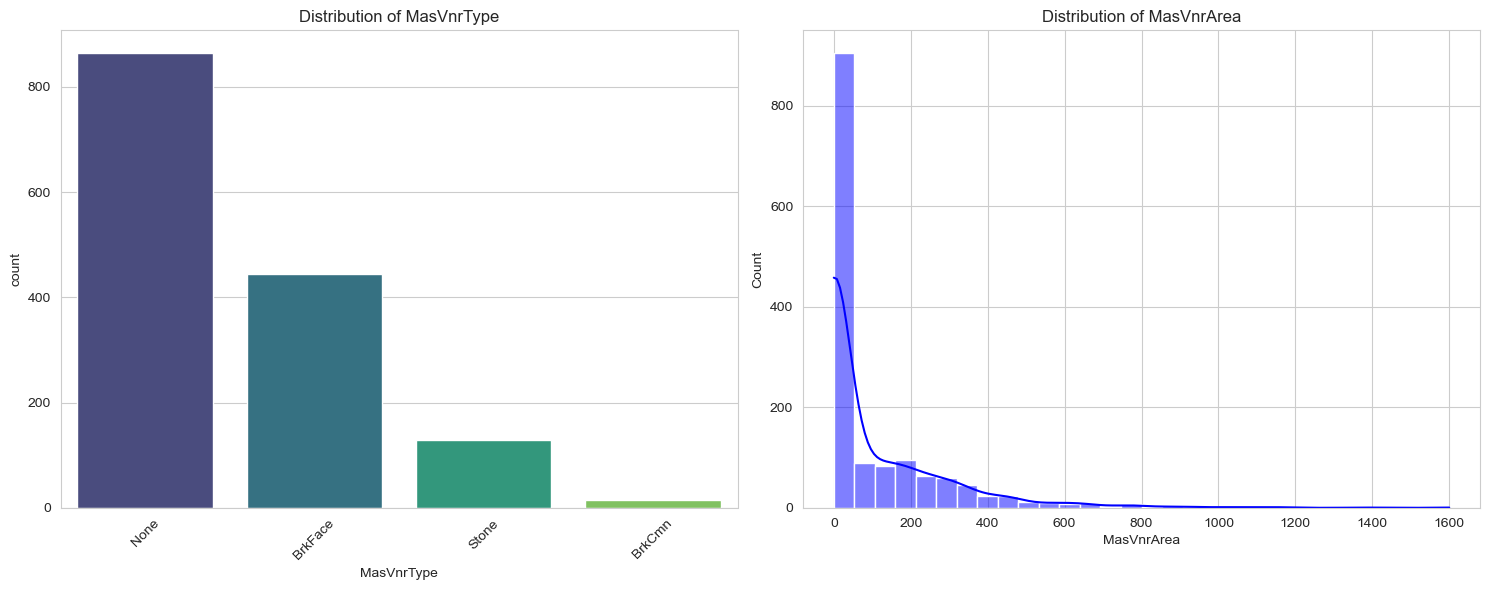

In [51]:
#Distribution of MasVnrType and MasVnR Area
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(data=df_train, x="MasVnrType", order=df_train["MasVnrType"].value_counts().index, palette="viridis", ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title("Distribution of MasVnrType")
sns.histplot(df_train["MasVnrArea"].dropna(), bins=30, kde=True, ax=axes[1], color="blue")
axes[1].set_title("Distribution of MasVnrArea")
plt.tight_layout()
plt.show()


Based on the distribution analysis for MasVnrType most common value (mode) is "None", so we fill missing values with "None". For MasVnrArea, since "None" in MasVnrType corresponds to 0 in MasVnrArea, we fill its missing values with 0.


In [52]:
#Fill missing values in MasVnrType with "None" (based on mode)
df_train["MasVnrType"].fillna("None", inplace=True)
df_test["MasVnrType"].fillna("None", inplace=True)

#Fill missing values in MasVnrArea with 0 (since "None" means no masonry veneer)
df_train["MasVnrArea"].fillna(0, inplace=True)
df_test["MasVnrArea"].fillna(0, inplace=True)

C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\1729388791.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train["MasVnrType"].fillna("None", inplace=True)
C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\1729388791.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [53]:
#There was one instance where the area is 198 and the type is missing. Since missing type was filled with “None”  I decided to also make area of that instance zero. 
before_change = df_test.loc[df_test.index == 1150, ["MasVnrType", "MasVnrArea"]]
df_test.loc[df_test.index == 1150, "MasVnrArea"] = 0
after_change = df_test.loc[df_test.index == 1150, ["MasVnrType", "MasVnrArea"]]

before_change, after_change

(     MasVnrType  MasVnrArea
 1150       None       198.0,
      MasVnrType  MasVnrArea
 1150       None         0.0)

In [54]:
display(missing_values_info(df_train))
display(missing_values_info(df_test))

Missing Count  Missing Percentage Data Type
LotFrontage             259           17.739726   float64
BsmtQual                 37            2.534247    object
BsmtCond                 37            2.534247    object
BsmtExposure             38            2.602740    object
BsmtFinType1             37            2.534247    object
BsmtFinType2             38            2.602740    object
Electrical                1            0.068493    object
FireplaceQu             690           47.260274    object
GarageType               81            5.547945    object
GarageYrBlt              81            5.547945   float64
GarageFinish             81            5.547945    object
GarageQual               81            5.547945    object
GarageCond               81            5.547945    object

Missing Count  Missing Percentage Data Type
MSZoning                  4            0.274160    object
LotFrontage             227           15.558602   float64
Utilities                 2            0.137080    object
Exterior1st               1            0.068540    object
Exterior2nd               1            0.068540    object
BsmtQual                 44            3.015764    object
BsmtCond                 45            3.084304    object
BsmtExposure             44            3.015764    object
BsmtFinType1             42            2.878684    object
BsmtFinSF1                1            0.068540   float64
BsmtFinType2             42            2.878684    object
BsmtFinSF2                1            0.068540   float64
BsmtUnfSF                 1            0.068540   float64
TotalBsmtSF               1            0.068540   float64
BsmtFullBath              2            0.137080   float64
BsmtHalfBath              2            0.137080   float64
KitchenQual               1            0.068540    object
Functional                2            0.137080    object
FireplaceQu             730           50.034270    object
GarageType               76            5.209047    object
GarageYrBlt              78            5.346127   float64
GarageFinish             78            5.346127    object
GarageCars                1            0.068540   float64
GarageArea                1            0.068540   float64
GarageQual               78            5.346127    object
GarageCond               78            5.346127    object
SaleType                  1            0.068540    object

*Basement features*

In [55]:
#TotalBsmtSF is 0, set categorical features to "None" and numerical features to 0
bsmt_categorical = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
#bsmt_numerical = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"]
bsmt_numerical = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "BsmtFullBath", "BsmtHalfBath"]
# Apply transformation to both train and test datasets
for col in bsmt_categorical:
    df_train.loc[df_train["TotalBsmtSF"] == 0, col] = "None"
    df_test.loc[df_test["TotalBsmtSF"] == 0, col] = "None"

for col in bsmt_numerical:
    df_train.loc[df_train["TotalBsmtSF"] == 0, col] = 0
    df_test.loc[df_test["TotalBsmtSF"] == 0, col] = 0

bsmt_numerical = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"]


In [56]:
display(missing_values_info(df_train))
display(missing_values_info(df_test))

Missing Count  Missing Percentage Data Type
LotFrontage             259           17.739726   float64
BsmtExposure              1            0.068493    object
BsmtFinType2              1            0.068493    object
Electrical                1            0.068493    object
FireplaceQu             690           47.260274    object
GarageType               81            5.547945    object
GarageYrBlt              81            5.547945   float64
GarageFinish             81            5.547945    object
GarageQual               81            5.547945    object
GarageCond               81            5.547945    object

Missing Count  Missing Percentage Data Type
MSZoning                  4            0.274160    object
LotFrontage             227           15.558602   float64
Utilities                 2            0.137080    object
Exterior1st               1            0.068540    object
Exterior2nd               1            0.068540    object
BsmtQual                  3            0.205620    object
BsmtCond                  4            0.274160    object
BsmtExposure              3            0.205620    object
BsmtFinType1              1            0.068540    object
BsmtFinSF1                1            0.068540   float64
BsmtFinType2              1            0.068540    object
BsmtFinSF2                1            0.068540   float64
BsmtUnfSF                 1            0.068540   float64
TotalBsmtSF               1            0.068540   float64
BsmtFullBath              1            0.068540   float64
BsmtHalfBath              1            0.068540   float64
KitchenQual               1            0.068540    object
Functional                2            0.137080    object
FireplaceQu             730           50.034270    object
GarageType               76            5.209047    object
GarageYrBlt              78            5.346127   float64
GarageFinish             78            5.346127    object
GarageCars                1            0.068540   float64
GarageArea                1            0.068540   float64
GarageQual               78            5.346127    object
GarageCond               78            5.346127    object
SaleType                  1            0.068540    object

In [57]:
# Display rows in train dataset where basement-related features have missing values
print("Missing Basement Rows in Train:")
display(df_train[df_train[bsmt_categorical + bsmt_numerical].isnull().any(axis=1)][bsmt_categorical + bsmt_numerical])

# Display rows in test dataset where basement-related features have missing values
print("\nMissing Basement Rows in Test:")
display(df_test[df_test[bsmt_categorical + bsmt_numerical].isnull().any(axis=1)][bsmt_categorical + bsmt_numerical])


Missing Basement Rows in Train:


BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  BsmtFinSF1  \
332       Gd       TA           No          GLQ          NaN        1124   
948       Gd       TA          NaN          Unf          Unf           0   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  
332         479       1603         3206             1             0  
948           0        936          936             0             0


Missing Basement Rows in Test:


BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  BsmtFinSF1  \
27         Gd       TA          NaN          Unf          Unf         0.0   
580        Gd      NaN           Mn          GLQ          Rec      1044.0   
660       NaN      NaN          NaN          NaN          NaN         NaN   
725        TA      NaN           No          BLQ          Unf      1033.0   
757       NaN       Fa           No          Unf          Unf         0.0   
758       NaN       TA           No          Unf          Unf         0.0   
888        Gd       TA          NaN          Unf          Unf         0.0   
1064       TA      NaN           Av          ALQ          Unf       755.0   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  
27           0.0     1595.0       1595.0           0.0           0.0  
580        382.0        0.0       1426.0           1.0           0.0  
660          NaN        NaN          NaN           NaN           NaN  
725          0.0       94.0       1127.0           0.0           1.0  
757          0.0      173.0        173.0           0.0           0.0  
758          0.0      356.0        356.0           0.0           0.0  
888          0.0      725.0        725.0           0.0           0.0  
1064         0.0      240.0        995.0           0.0           0.0

C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\3825663854.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index, palette="viridis", ax=axes[i])
C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\3825663854.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\3825663854.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index, palette="viridis", ax=axes[i])
C:\Users\aaliu\Ap

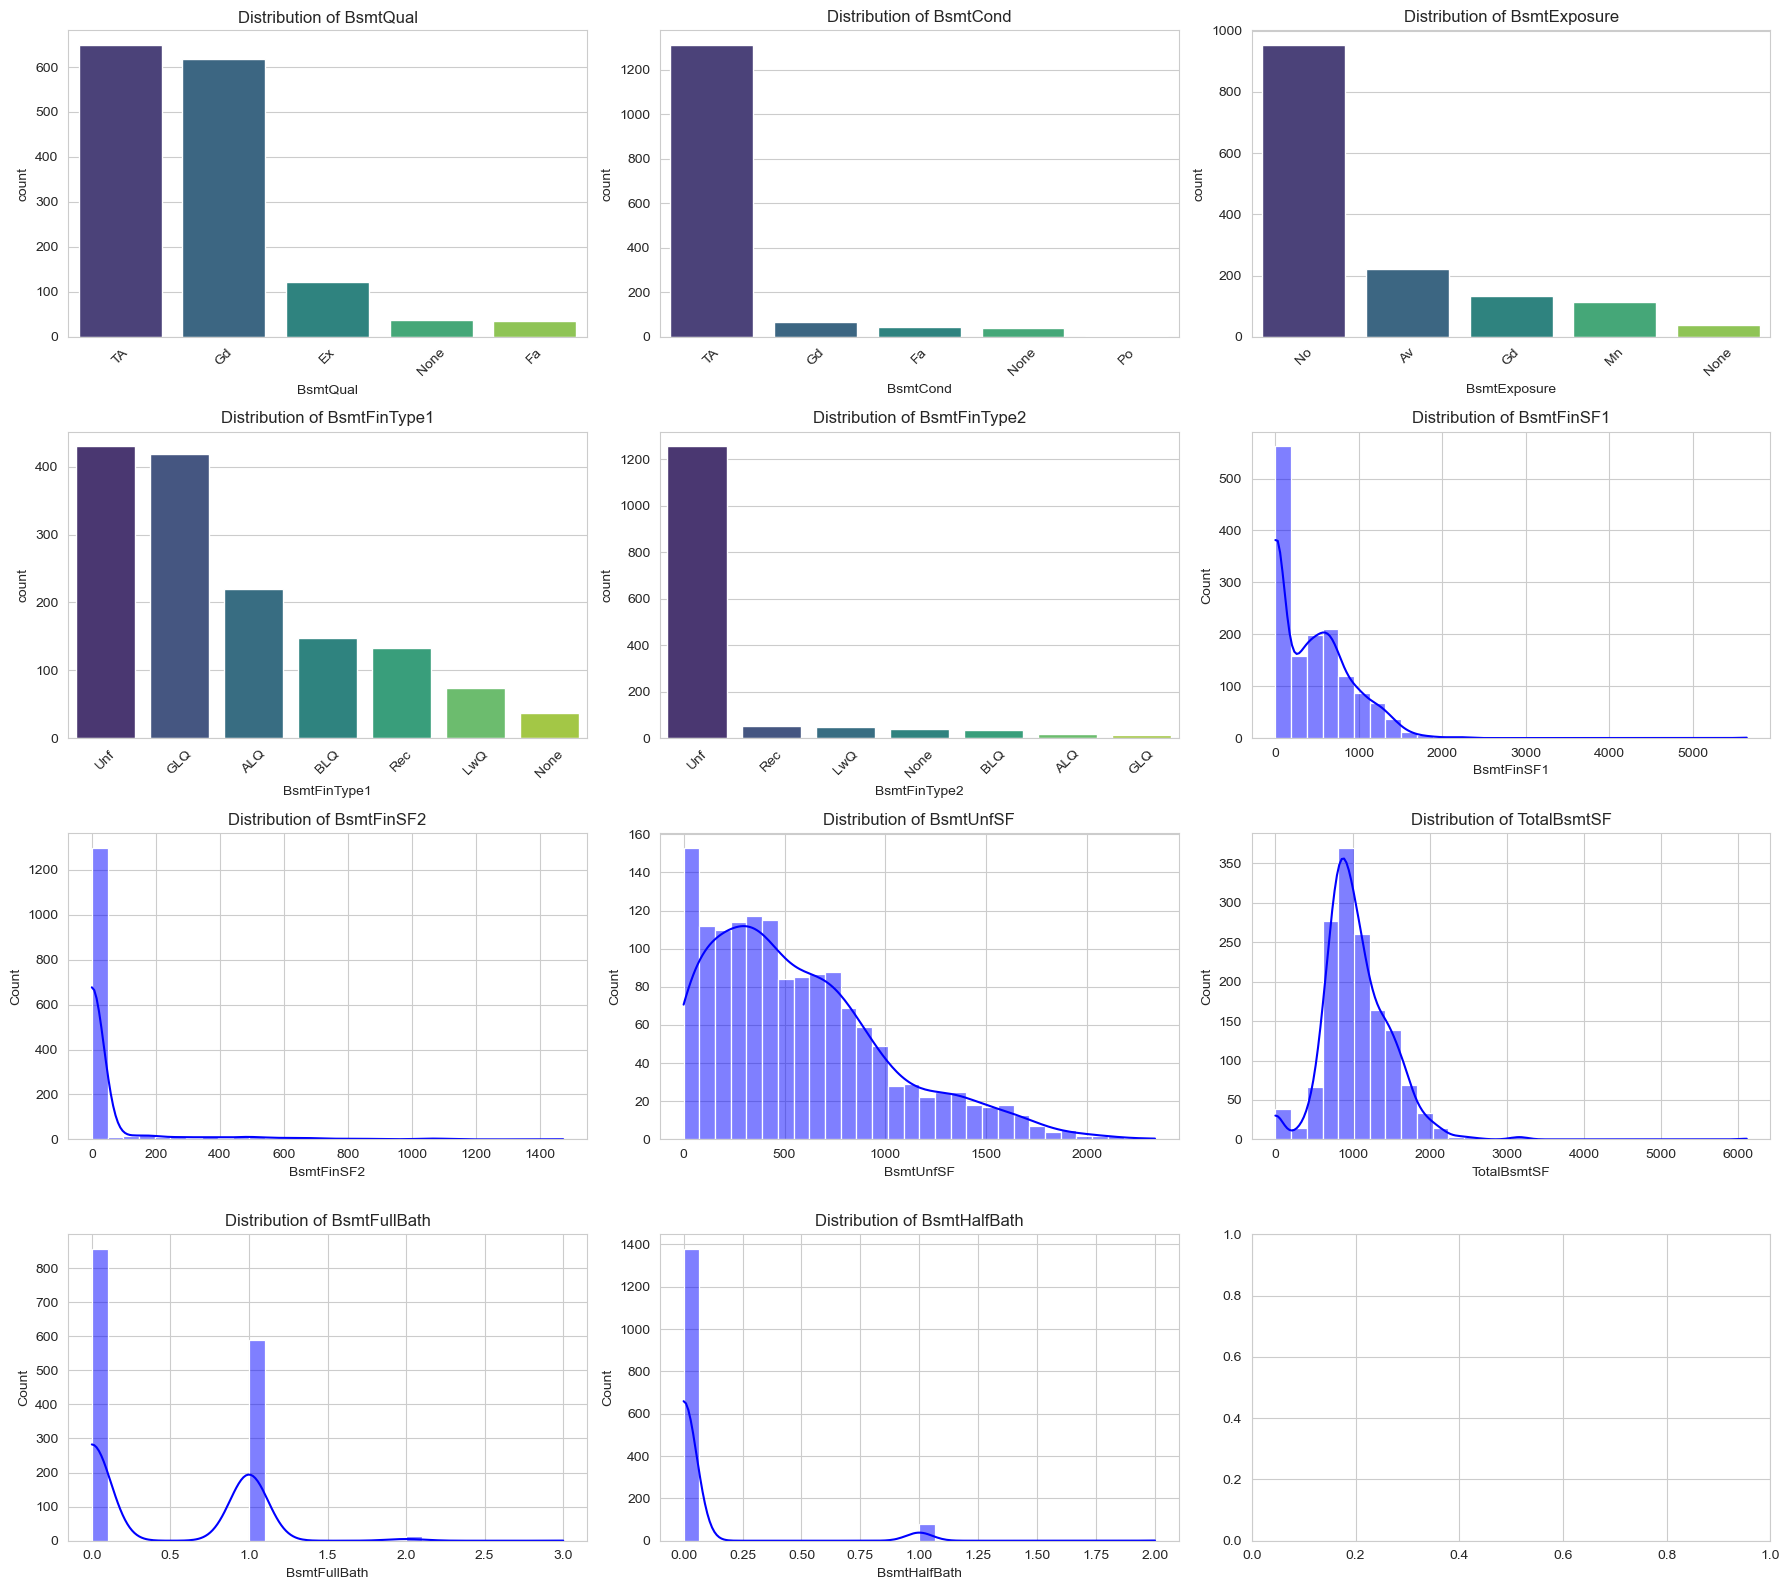

In [58]:
#Distribution of Basement Features
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
axes = axes.flatten()
bsmt_features = bsmt_categorical + bsmt_numerical
for i, col in enumerate(bsmt_features):
    if df_train[col].dtype == "object":  
        sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index, palette="viridis", ax=axes[i])
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    else:  
        sns.histplot(df_train[col], bins=30, kde=True, ax=axes[i], color="blue")

    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


In [59]:
# Fill TotalBsmtSF NaN in test set with 0 (assuming no basement)
df_test["TotalBsmtSF"].fillna(0, inplace=True) #660 instance of test set
bsmt_numerical = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "BsmtFullBath", "BsmtHalfBath"]
# If TotalBsmtSF is 0, set categorical basement features to "None" and numerical to 0
for col in bsmt_categorical:
    #df_train.loc[df_train["TotalBsmtSF"] == 0, col] = "None"
    df_test.loc[df_test["TotalBsmtSF"] == 0, col] = "None"

for col in bsmt_numerical:
    #df_train.loc[df_train["TotalBsmtSF"] == 0, col] = 0
    df_test.loc[df_test["TotalBsmtSF"] == 0, col] = 0

# Fill remaining NaN values in categorical features using mode from train
bsmt_mode_values = df_train[bsmt_categorical].mode().iloc[0]  # Mode for each categorical column
for col in bsmt_categorical:
    df_train[col].fillna(bsmt_mode_values[col], inplace=True)
    df_test[col].fillna(bsmt_mode_values[col], inplace=True)

# Fill remaining NaN values in numerical features using median from train
bsmt_median_values = df_train[bsmt_numerical].median()  # Median for each numerical column
for col in bsmt_numerical:
    df_train[col].fillna(bsmt_median_values[col], inplace=True)
    df_test[col].fillna(bsmt_median_values[col], inplace=True)




C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\3661992750.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test["TotalBsmtSF"].fillna(0, inplace=True) #660 instance of test set
C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\3661992750.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [60]:
display(missing_values_info(df_train))
display(missing_values_info(df_test))

Missing Count  Missing Percentage Data Type
LotFrontage             259           17.739726   float64
Electrical                1            0.068493    object
FireplaceQu             690           47.260274    object
GarageType               81            5.547945    object
GarageYrBlt              81            5.547945   float64
GarageFinish             81            5.547945    object
GarageQual               81            5.547945    object
GarageCond               81            5.547945    object

Missing Count  Missing Percentage Data Type
MSZoning                  4            0.274160    object
LotFrontage             227           15.558602   float64
Utilities                 2            0.137080    object
Exterior1st               1            0.068540    object
Exterior2nd               1            0.068540    object
KitchenQual               1            0.068540    object
Functional                2            0.137080    object
FireplaceQu             730           50.034270    object
GarageType               76            5.209047    object
GarageYrBlt              78            5.346127   float64
GarageFinish             78            5.346127    object
GarageCars                1            0.068540   float64
GarageArea                1            0.068540   float64
GarageQual               78            5.346127    object
GarageCond               78            5.346127    object
SaleType                  1            0.068540    object

*Fire place quality* 

In [61]:
# Fill missing values in FireplaceQu with "None" (since NA means no fireplace)
df_train["FireplaceQu"].fillna("None", inplace=True)
df_test["FireplaceQu"].fillna("None", inplace=True)



C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\3170699846.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train["FireplaceQu"].fillna("None", inplace=True)
C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\3170699846.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

*Electrical*

In [62]:
# Fill missing values in Electrical with "None" (assuming NA means no electrical system)
df_train["Electrical"].fillna("None", inplace=True)



C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\1196083385.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train["Electrical"].fillna("None", inplace=True)


*Garage Features*

C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\2917737589.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x=col, ax=axes[i], order=df_train[col].value_counts().index, palette="viridis")
C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\2917737589.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\2917737589.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x=col, ax=axes[i], order=df_train[col].value_counts().index, palette="viridis")
C:\Users\aaliu\A

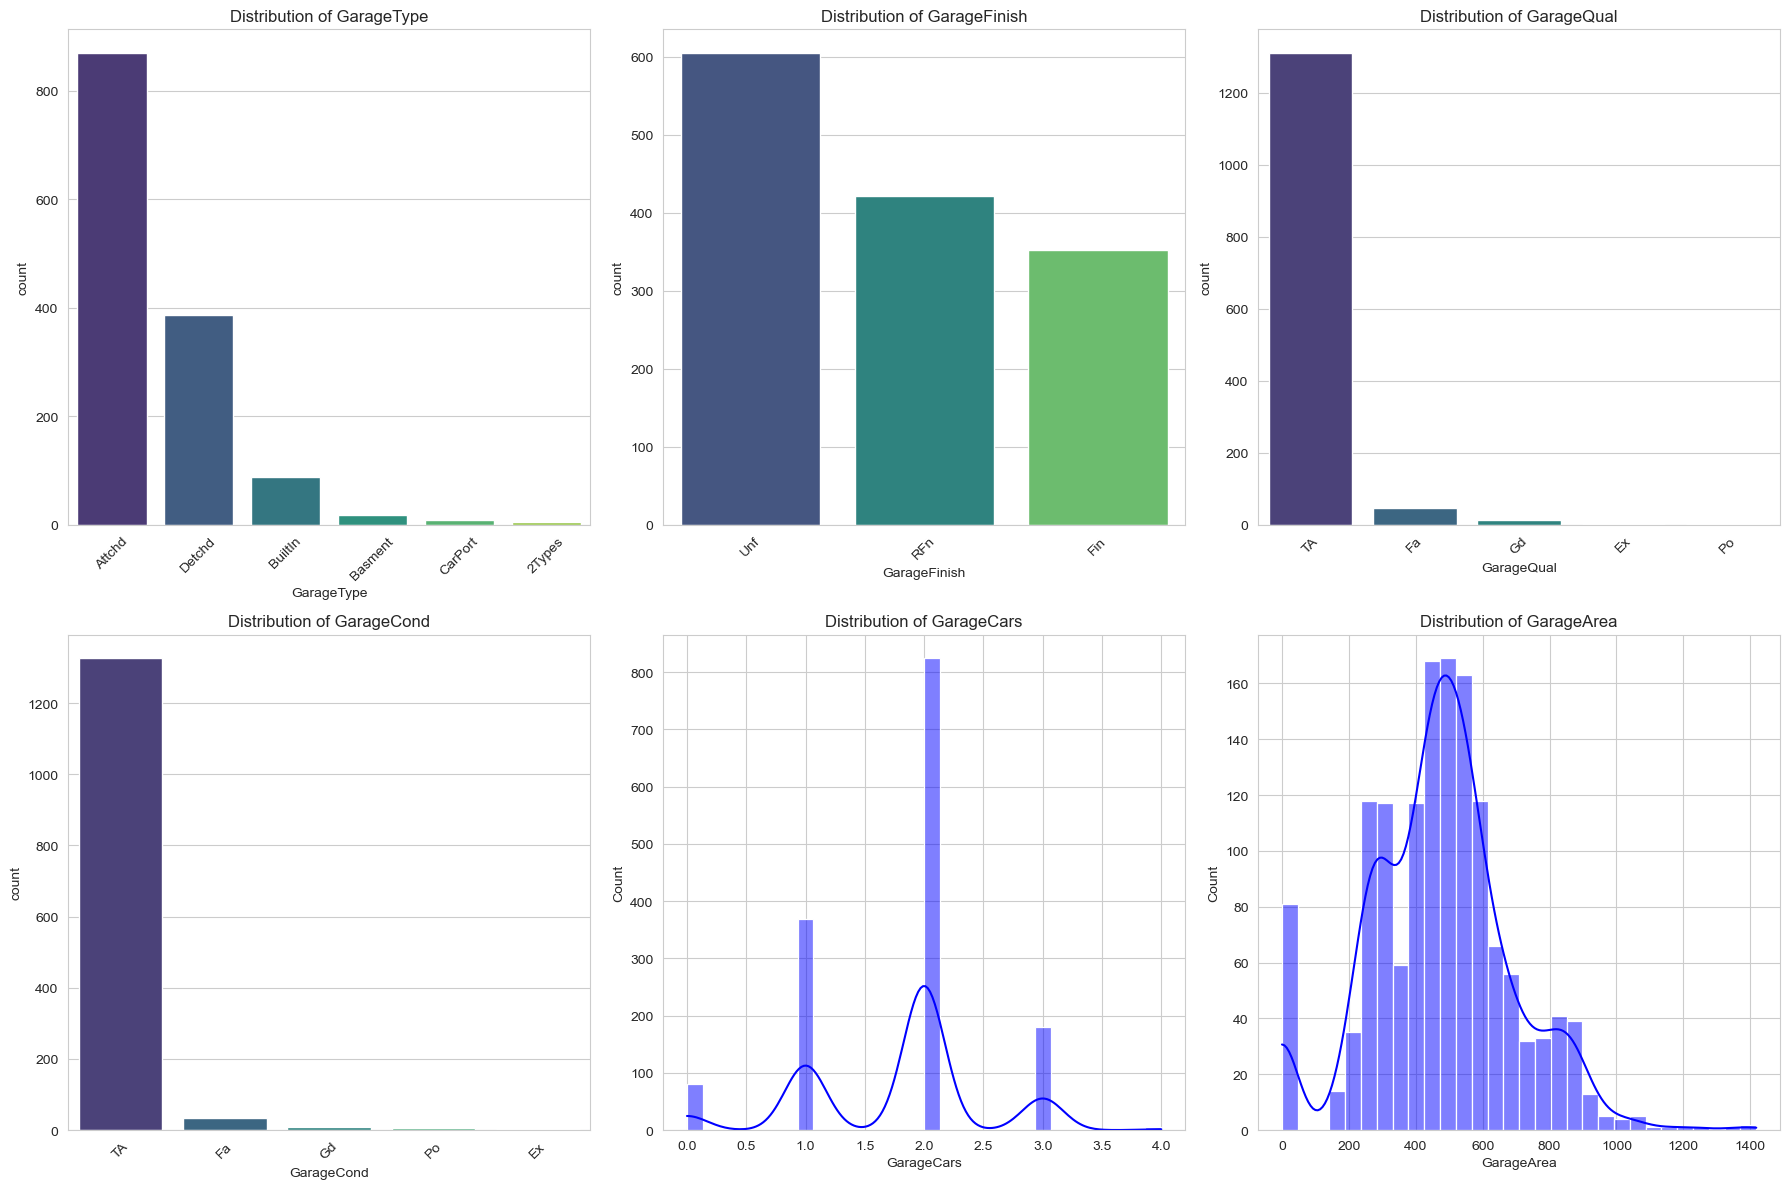

In [63]:
#Distribution of Garage related features
# List of garage-related features
garage_features = ["GarageType", "GarageFinish", "GarageQual", "GarageCond", "GarageCars", "GarageArea"]
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()
for i, col in enumerate(garage_features):
    if df_train[col].dtype == "object":  # Categorical features
        sns.countplot(data=df_train, x=col, ax=axes[i], order=df_train[col].value_counts().index, palette="viridis")
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    else:  # Numerical features
        sns.histplot(df_train[col], bins=30, kde=True, ax=axes[i], color="blue")

    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


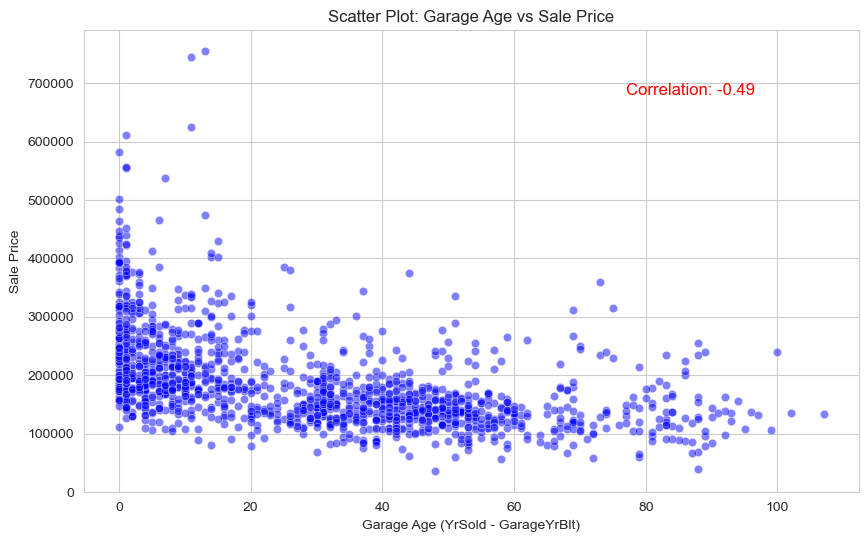

In [64]:
#Scatter plot of GarageAge vs SalePrice
df_train_copy = df_train.copy()
df_train_copy["GarageAge"] = df_train_copy["YrSold"] - df_train_copy["GarageYrBlt"]
garage_age_filtered = df_train_copy.dropna(subset=["GarageAge"])
correlation = np.corrcoef(garage_age_filtered["GarageAge"], garage_age_filtered["SalePrice"])[0, 1]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=garage_age_filtered, x="GarageAge", y="SalePrice", alpha=0.5, color="blue")
plt.text(x=garage_age_filtered["GarageAge"].max() - 30, 
         y=garage_age_filtered["SalePrice"].max() * 0.9, 
         s=f"Correlation: {correlation:.2f}", fontsize=12, color="red")
plt.xlabel("Garage Age (YrSold - GarageYrBlt)")
plt.ylabel("Sale Price")
plt.title("Scatter Plot: Garage Age vs Sale Price")
plt.show()


Based on the negative correlation (-0.49) between Garage Age and Sale Price, missing garage values likely decrease the sale price.

In [65]:
# List of garage-related categorical and numerical features
garage_categorical = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
garage_numerical = ["GarageCars", "GarageArea"]

#Fill missing GarageYrBlt with YearBuilt
#df_train["GarageYrBlt"].fillna(df_train["YearBuilt"], inplace=True)
#df_test["GarageYrBlt"].fillna(df_test["YearBuilt"], inplace=True)

# If GarageArea is 0, set GarageYrBlt to YrSold (indicating no garage at sale time)
df_train.loc[df_train["GarageArea"] == 0, "GarageYrBlt"] = df_train["YrSold"]
df_test.loc[df_test["GarageArea"] == 0, "GarageYrBlt"] = df_test["YrSold"]

#If GarageArea is 0, set categorical features to "None" and numerical features to 0
for col in garage_categorical:
    df_train.loc[df_train["GarageArea"] == 0, col] = "None"
    df_test.loc[df_test["GarageArea"] == 0, col] = "None"

for col in garage_numerical:
    df_train.loc[df_train["GarageArea"] == 0, col] = 0
    df_test.loc[df_test["GarageArea"] == 0, col] = 0





In [66]:
display(missing_values_info(df_train))
display(missing_values_info(df_test))

Missing Count  Missing Percentage Data Type
LotFrontage            259           17.739726   float64

Missing Count  Missing Percentage Data Type
MSZoning                  4            0.274160    object
LotFrontage             227           15.558602   float64
Utilities                 2            0.137080    object
Exterior1st               1            0.068540    object
Exterior2nd               1            0.068540    object
KitchenQual               1            0.068540    object
Functional                2            0.137080    object
GarageYrBlt               2            0.137080   float64
GarageFinish              2            0.137080    object
GarageCars                1            0.068540   float64
GarageArea                1            0.068540   float64
GarageQual                2            0.137080    object
GarageCond                2            0.137080    object
SaleType                  1            0.068540    object

In [67]:
# List of garage-related categorical and numerical features
garage_categorical = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
garage_numerical = ["GarageCars", "GarageArea","GarageYrBlt"]

# Display rows in train dataset where garage-related features have missing values
display(df_train[df_train[garage_categorical + garage_numerical].isnull().any(axis=1)][garage_categorical + garage_numerical])

# Display rows in test dataset where garage-related features have missing values
display(df_test[df_test[garage_categorical + garage_numerical].isnull().any(axis=1)][garage_categorical + garage_numerical])


Empty DataFrame
Columns: [GarageType, GarageFinish, GarageQual, GarageCond, GarageCars, GarageArea, GarageYrBlt]
Index: []

GarageType GarageFinish GarageQual GarageCond  GarageCars  GarageArea  \
666      Detchd          NaN        NaN        NaN         1.0       360.0   
1116     Detchd          NaN        NaN        NaN         NaN         NaN   

      GarageYrBlt  
666           NaN  
1116          NaN

If GarageType is present but other values are missing, use mode (most common value) from train.
If GarageType is present but numerical values are missing, use median from train.


In [68]:
#Fill missing categorical values with mode from train dataset
garage_categorical = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
garage_numerical = ["GarageCars", "GarageArea",]
df_test["GarageYrBlt"].fillna(df_test["YearBuilt"], inplace=True)

garage_mode_values = df_train[garage_categorical].mode().iloc[0]

for col in garage_categorical:
    df_train[col].fillna(garage_mode_values[col], inplace=True)
    df_test[col].fillna(garage_mode_values[col], inplace=True)

#Fill missing numerical values with median from train dataset
garage_median_values = df_train[garage_numerical].median()

for col in garage_numerical:
    df_train[col].fillna(garage_median_values[col], inplace=True)
    df_test[col].fillna(garage_median_values[col], inplace=True)



C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\2347060818.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test["GarageYrBlt"].fillna(df_test["YearBuilt"], inplace=True)
C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\2347060818.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [69]:
display(missing_values_info(df_train))
display(missing_values_info(df_test))

Missing Count  Missing Percentage Data Type
LotFrontage            259           17.739726   float64

Missing Count  Missing Percentage Data Type
MSZoning                 4            0.274160    object
LotFrontage            227           15.558602   float64
Utilities                2            0.137080    object
Exterior1st              1            0.068540    object
Exterior2nd              1            0.068540    object
KitchenQual              1            0.068540    object
Functional               2            0.137080    object
SaleType                 1            0.068540    object

*MSZoning*

C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\302311098.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x="MSZoning", order=df_train["MSZoning"].value_counts().index, palette="viridis")


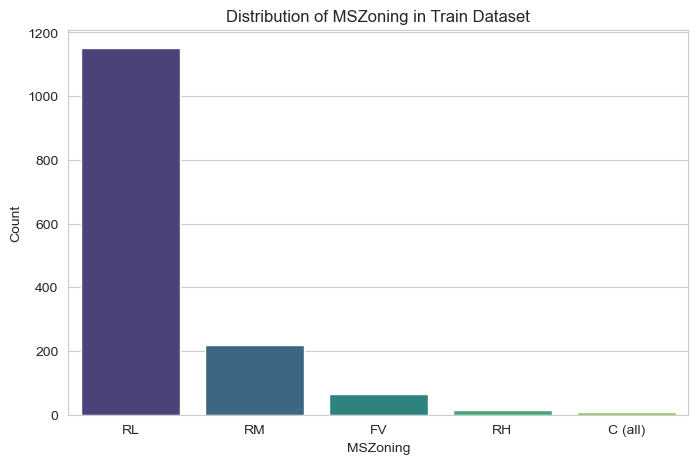

In [70]:
#Distribution of MsZoning
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(data=df_train, x="MSZoning", order=df_train["MSZoning"].value_counts().index, palette="viridis")
plt.xlabel("MSZoning")
plt.ylabel("Count")
plt.title("Distribution of MSZoning in Train Dataset")
plt.show()


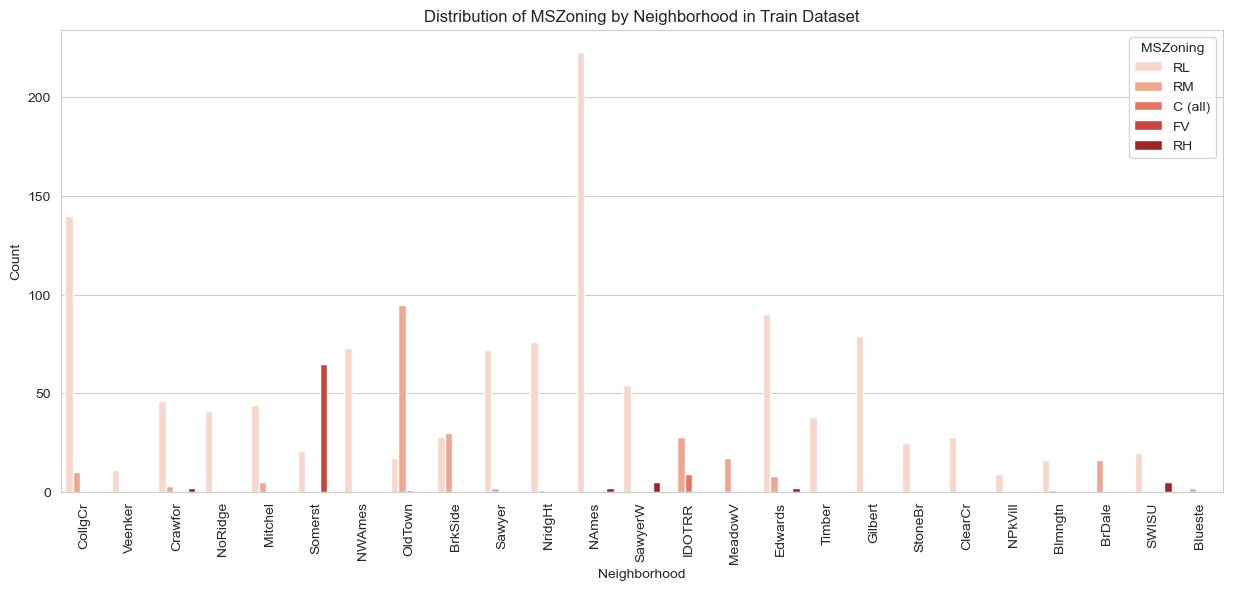

In [71]:
# MSZoning distribution by Neighborhood
zoning_by_neighborhood = df_train.groupby("Neighborhood")["MSZoning"].agg(lambda x: x.mode()[0])
plt.figure(figsize=(15, 6))
sns.countplot(data=df_train, x="Neighborhood", hue="MSZoning", palette="Reds")
plt.xticks(rotation=90)
plt.xlabel("Neighborhood")
plt.ylabel("Count")
plt.title("Distribution of MSZoning by Neighborhood in Train Dataset")
plt.legend(title="MSZoning")
plt.show()

In [72]:
# Fill missing MSZoning values in the test set with the mode from train set
df_test["MSZoning"].fillna(df_train["MSZoning"].mode()[0], inplace=True)


C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\445958690.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test["MSZoning"].fillna(df_train["MSZoning"].mode()[0], inplace=True)


*Lot Fronatge*

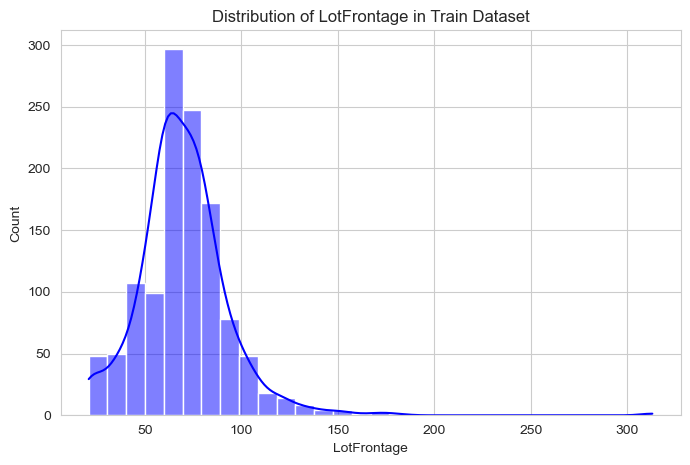

In [73]:
#Distribution of Lot Frontage
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.histplot(df_train["LotFrontage"], bins=30, kde=True, color="blue")
plt.xlabel("LotFrontage")
plt.ylabel("Count")
plt.title("Distribution of LotFrontage in Train Dataset")
plt.show()

In [74]:
# Compute the median LotFrontage for imputation
lotfrontage_median = df_train["LotFrontage"].median()

# Fill missing values in both train and test with median from train
df_train["LotFrontage"].fillna(lotfrontage_median, inplace=True)
df_test["LotFrontage"].fillna(lotfrontage_median, inplace=True)

C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\4112456108.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train["LotFrontage"].fillna(lotfrontage_median, inplace=True)
C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\4112456108.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [75]:
display(missing_values_info(df_train))
display(missing_values_info(df_test))

Empty DataFrame
Columns: [Missing Count, Missing Percentage, Data Type]
Index: []

Missing Count  Missing Percentage Data Type
Utilities                2             0.13708    object
Exterior1st              1             0.06854    object
Exterior2nd              1             0.06854    object
KitchenQual              1             0.06854    object
Functional               2             0.13708    object
SaleType                 1             0.06854    object

*Utilities, Exterior1st, Exterior2nd, KitchenQual, Functional, SaleType*

In [76]:
# Display rows in test dataset where the mentioned features have missing values
missing_features = ["Utilities", "Exterior1st", "Exterior2nd", "KitchenQual", "Functional", "SaleType"]

# Filter missing rows in test dataset
missing_rows_test = df_test[df_test[missing_features].isnull().any(axis=1)][missing_features]

print(missing_rows_test)


     Utilities Exterior1st Exterior2nd KitchenQual Functional SaleType
95      AllPub     Wd Sdng     Wd Sdng         NaN        Mod      COD
455        NaN     Wd Sdng     Wd Sdng          TA       Min1    ConLD
485        NaN     BrkFace     BrkFace          TA       Min2       WD
691     AllPub         NaN         NaN          Fa        Typ       WD
756     AllPub     AsbShng     VinylSd          Fa        NaN       WD
1013    AllPub     Wd Sdng     Wd Sdng          TA        NaN      COD
1029    AllPub     Plywood     Plywood          TA        Typ      NaN


C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\50293213.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index, palette="viridis", ax=axes[i])
C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\50293213.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\50293213.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index, palette="viridis", ax=axes[i])
C:\Users\aaliu\AppData\

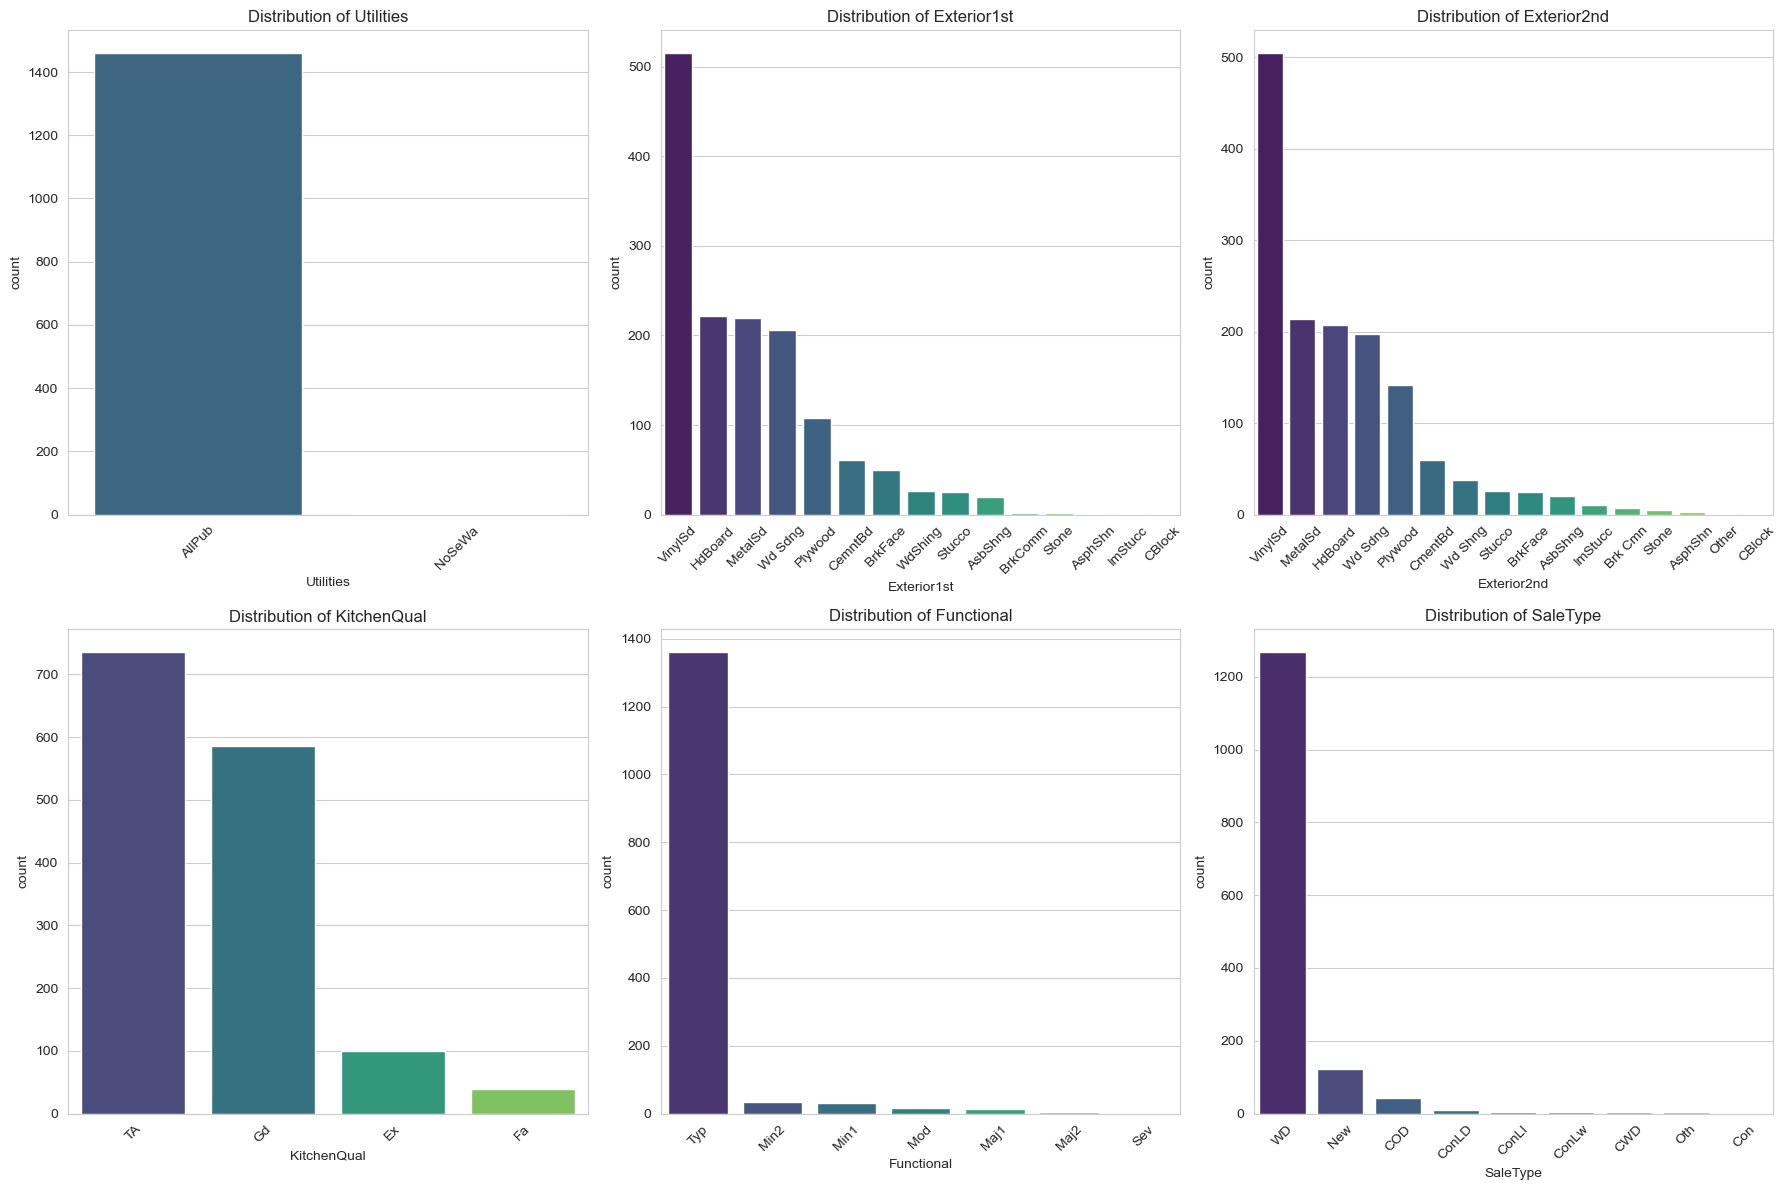

In [77]:
#Distribution of Utilities, Exterior1st, Exterior2nd, KitchenQual, Functional, SaleType
sns.set_style("whitegrid")
missing_features = ["Utilities", "Exterior1st", "Exterior2nd", "KitchenQual", "Functional", "SaleType"]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()
for i, col in enumerate(missing_features):
    sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index, palette="viridis", ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


In [78]:
# List of categorical features to impute
categorical_features = ["Utilities", "Exterior1st", "Exterior2nd", "KitchenQual", "Functional", "SaleType"]

# Fill missing categorical values with mode from train dataset
categorical_mode_values = df_train[categorical_features].mode().iloc[0]  # Get mode for each column

for col in categorical_features:
    df_test[col].fillna(categorical_mode_values[col], inplace=True)



C:\Users\aaliu\AppData\Local\Temp\ipykernel_29968\2912914634.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test[col].fillna(categorical_mode_values[col], inplace=True)


In [79]:
display(missing_values_info(df_train))
display(missing_values_info(df_test))

Empty DataFrame
Columns: [Missing Count, Missing Percentage, Data Type]
Index: []

Empty DataFrame
Columns: [Missing Count, Missing Percentage, Data Type]
Index: []

In [80]:
# Save cleaned train and test datasets
df_train.to_csv("test_train.csv", index=False)
df_test.to_csv("prediction.csv", index=False)


In [81]:
df_test_train=pd.read_csv("test_train.csv", na_values=["NA"], keep_default_na=False)
df_prediction=pd.read_csv("prediction.csv", na_values=["NA"], keep_default_na=False)

In [82]:
df_test_train.shape, df_prediction.shape

((1460, 77), (1459, 76))

# **Feature Engineering, Selection and Preprocessing**

In [83]:
categorical_cols = df_test_train.select_dtypes(include=['object']).columns
categorical_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

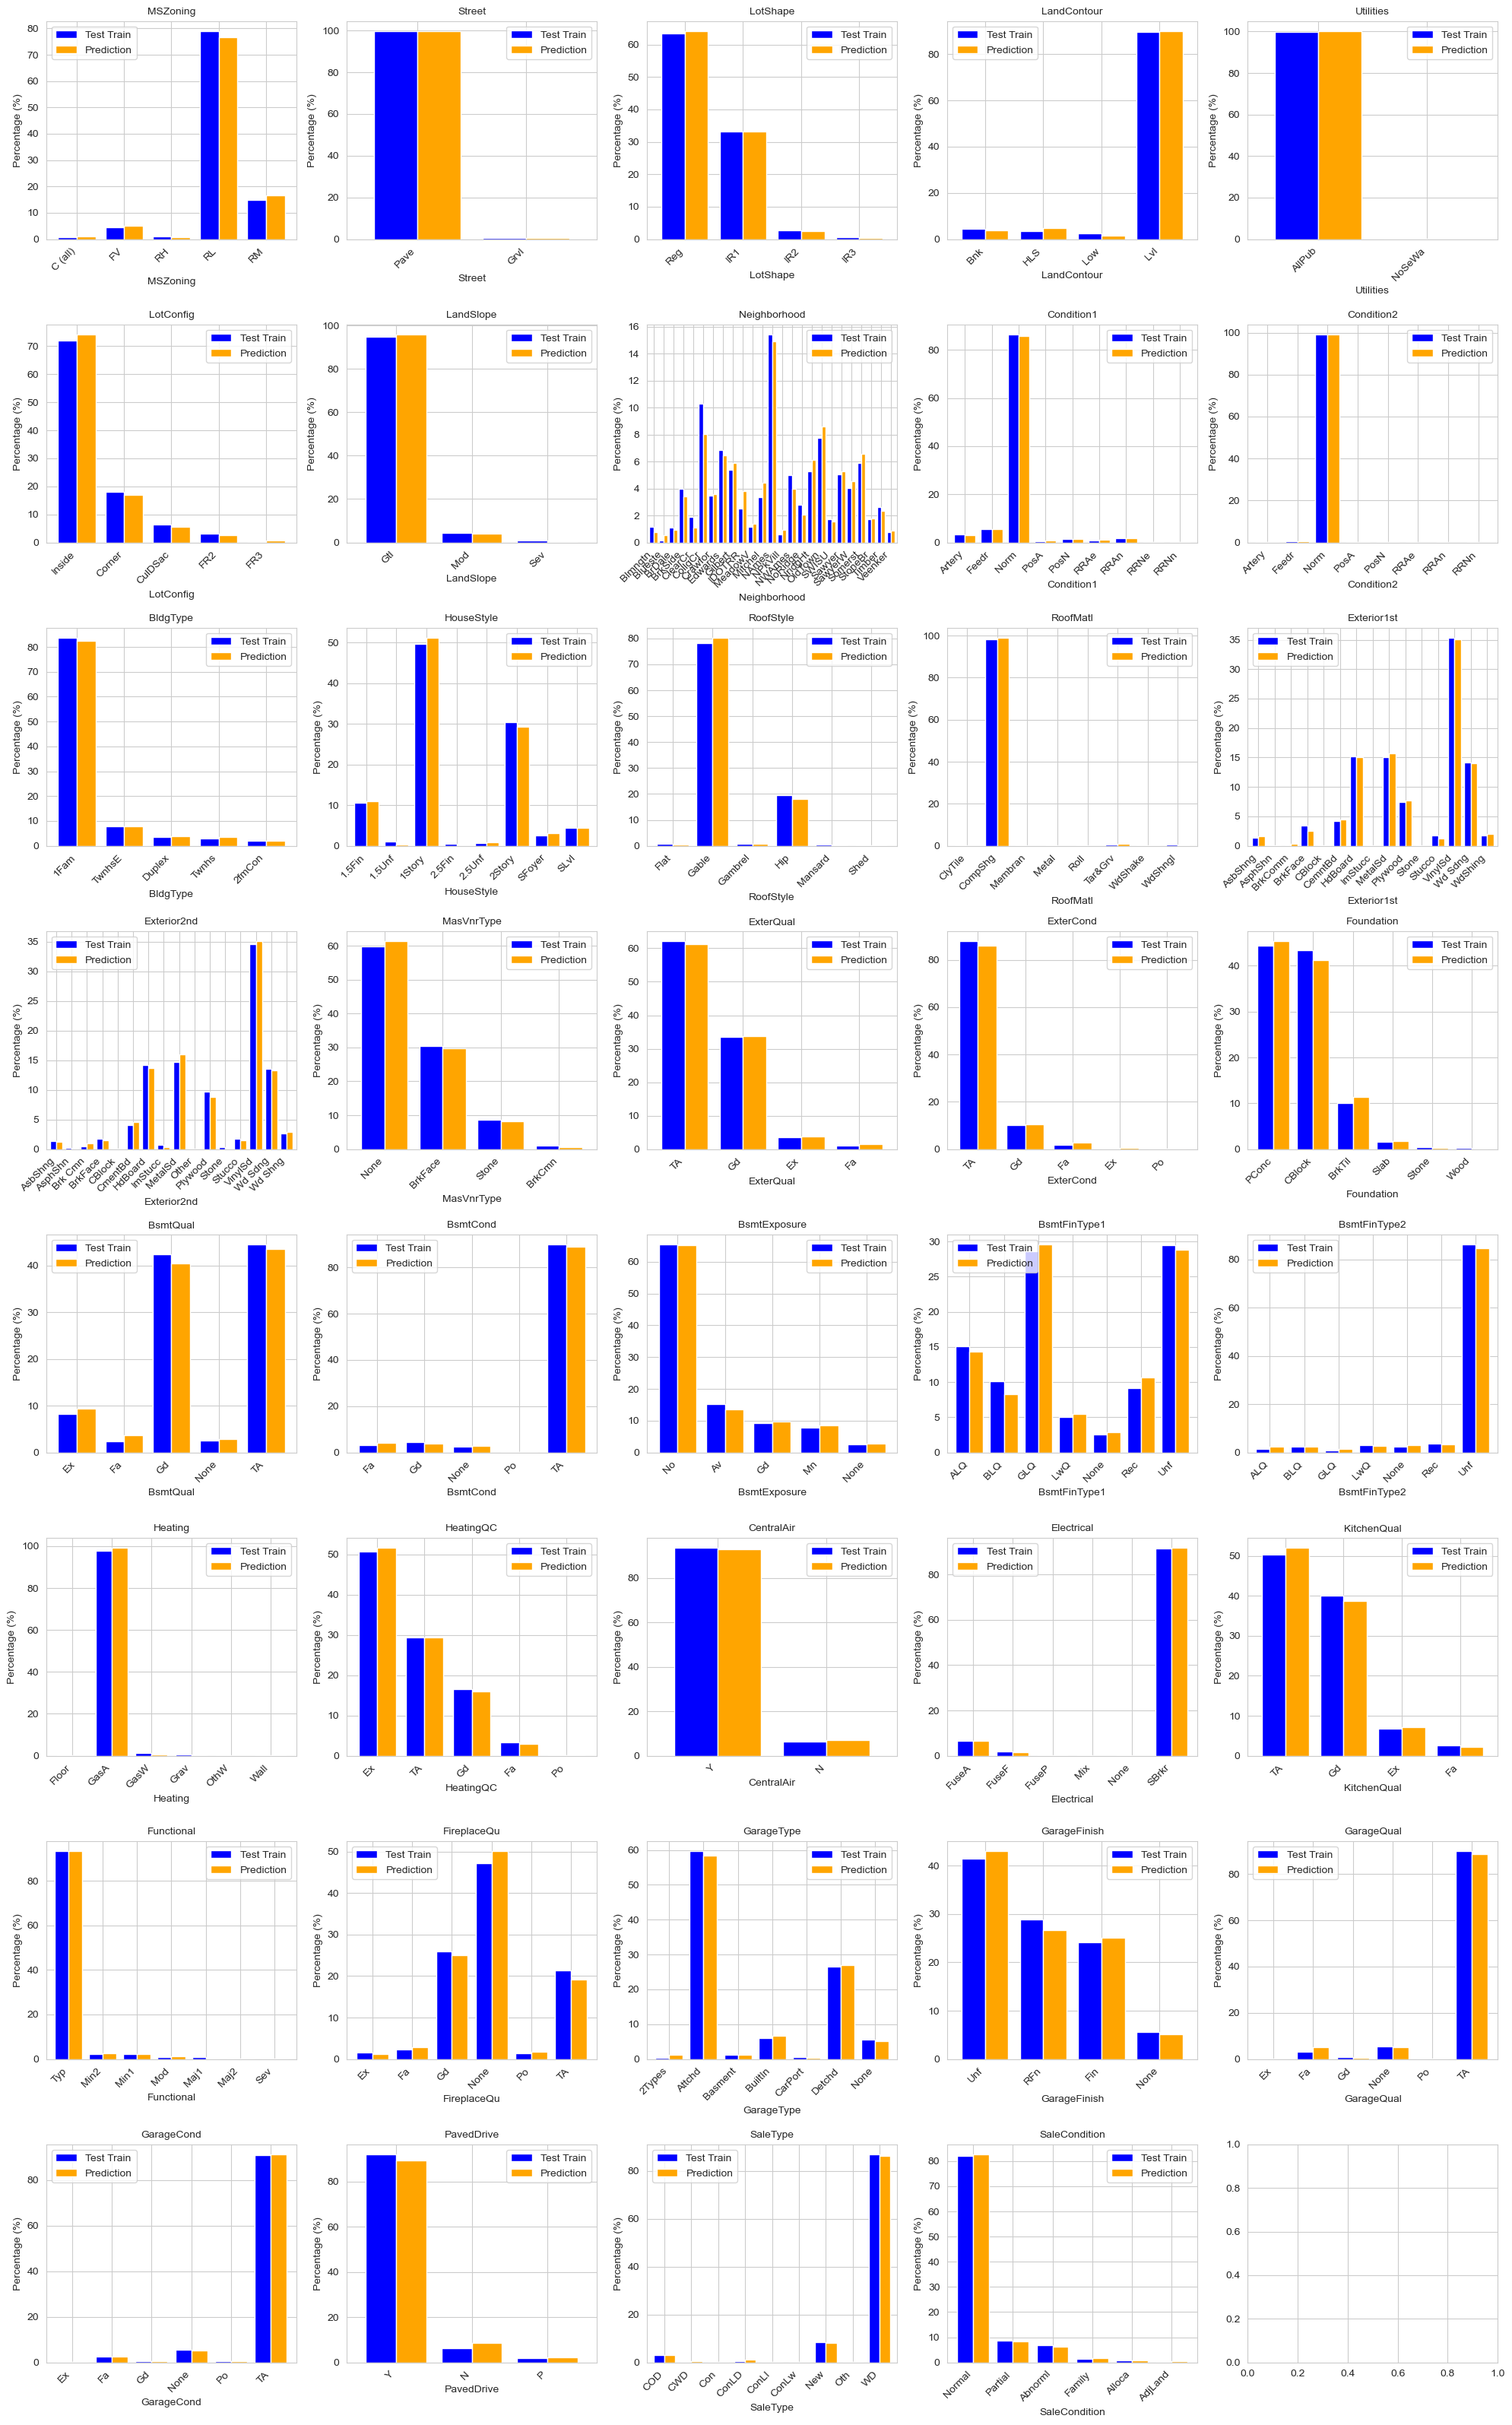

In [84]:
#Distribution of Catregorical Varibale in Test and Prediction
def category_percentage(df, column):
    """Return percentage distribution of categories in a given column."""
    counts = df[column].value_counts(dropna=False)
    total = len(df)
    return (counts / total) * 100
# Get categorical columns from the cleaned df_test_train dataset
categorical_cols = df_test_train.select_dtypes(include=['object']).columns
# Compute percentage distributions for selected categorical features
categorical_percentage_test_train = {feature: category_percentage(df_test_train, feature) for feature in categorical_cols}
categorical_percentage_prediction = {feature: category_percentage(df_prediction, feature) for feature in categorical_cols}
# Convert to DataFrame for better visualization
df_percentage_test_train = pd.DataFrame(categorical_percentage_test_train).T
df_percentage_prediction = pd.DataFrame(categorical_percentage_prediction).T
# Plot comparison using seaborn
fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(20, 32)) 
axes = axes.flatten()
for i, feature in enumerate(categorical_cols):
    ax = axes[i]
    # Combine data for a side-by-side comparison
    plot_data = pd.DataFrame({
        "Test Train": category_percentage(df_test_train, feature),
        "Prediction": category_percentage(df_prediction, feature)
    }).fillna(0)
    plot_data.plot(kind="bar", ax=ax, width=0.8, color=["blue", "orange"])
    ax.set_title(feature, fontsize=10)
    ax.set_ylabel("Percentage (%)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()



In [85]:
# Drop the highly imbalanced categories
features_to_drop = ["Condition2", "Heating", "RoofMatl", "Street", "Utilities"]
df_test_train.drop(columns=features_to_drop, inplace=True, errors='ignore')
df_prediction.drop(columns=features_to_drop, inplace=True, errors='ignore')


Nominal Features (Categorical with No Order). 

Encoding Choice: One-Hot Encoding (OHE). Since these categories have no inherent order, we should apply one-hot encoding to avoid imposing artificial numerical relationships.:

MSZoning – (Zoning classifications)
Neighborhood – (Geographical locations)
Condition1 – (Proximity to conditions)
BldgType – (Type of dwelling)
HouseStyle – (Architectural style)
RoofStyle – (Roof design)
Exterior1st – (Primary exterior material)
Exterior2nd – (Secondary exterior material)
MasVnrType – (Masonry veneer type)
Foundation – (Type of foundation)
CentralAir – (Yes/No air conditioning)
Electrical – (Type of electrical system)
GarageType – (Type of garage)
SaleType – (Type of sale)
SaleCondition – (Condition of sale)



Ordinal Features (Categorical with Meaningful Order)
Encoding Choice: Ordinal Encoding. Since these categories follow a ranked order, we should apply ordinal encoding using meaningful numerical mappings.



LotShape – (Regular → Irregular)
LandContour – (Flat → Hillside)
LotConfig – (Inside → Corner)
LandSlope – (Gentle → Severe)
ExterQual – (Poor → Excellent)
ExterCond – (Poor → Excellent)
BsmtQual – (No Basement → Excellent)
BsmtCond – (Poor → Excellent)
BsmtExposure – (No exposure → Good exposure)
BsmtFinType1 – (Unfinished → Good Living Quarters)
BsmtFinType2 – (Unfinished → Good Living Quarters)
HeatingQC – (Poor → Excellent)
KitchenQual – (Poor → Excellent)
Functional – (Salvage → Typical)
FireplaceQu – (No fireplace → Excellent)
GarageFinish – (Unfinished → Finished)
GarageQual – (Poor → Excellent)
GarageCond – (Poor → Excellent)
PavedDrive – (Dirt/Gravel → Paved)

*Nominal Categories*

In [86]:
# List of nominal features
nominal_features = [
    "MSZoning", "Neighborhood", "Condition1", "BldgType", "HouseStyle", "RoofStyle", 
    "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "CentralAir", "Electrical", 
    "GarageType", "SaleType", "SaleCondition"
]


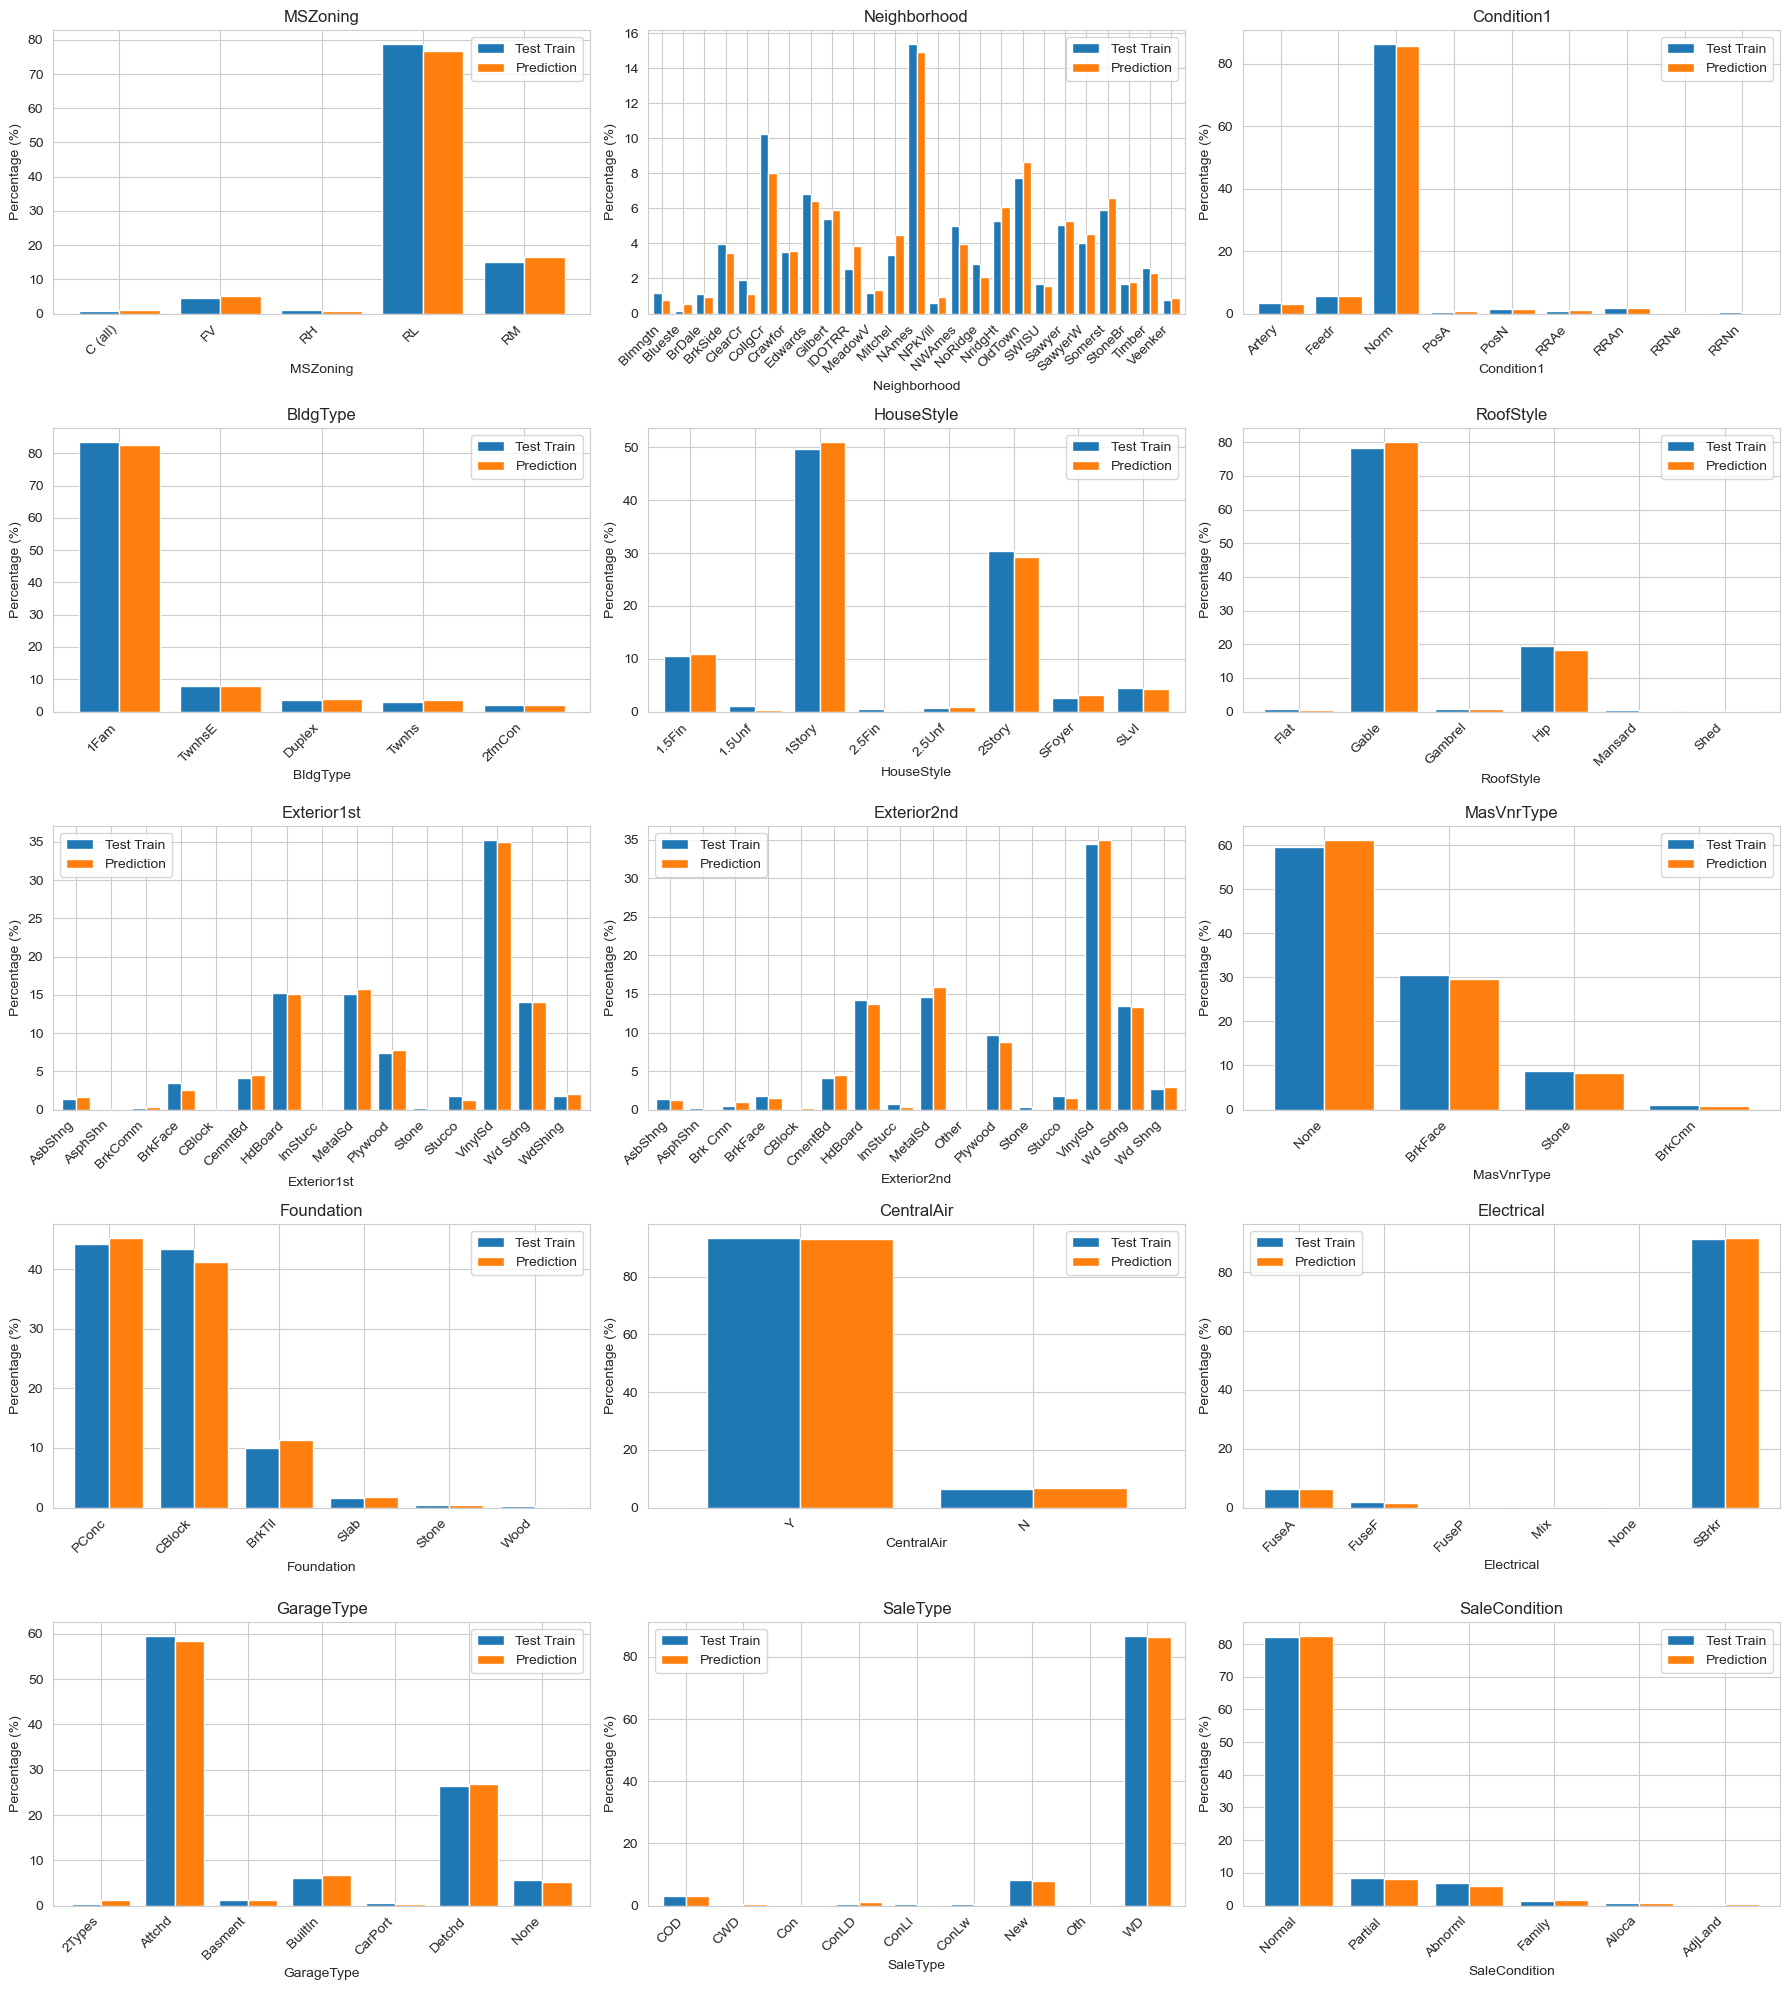

In [87]:
# Function to calculate category percentages
def category_percentage(df, feature):
    return (df[feature].value_counts(normalize=True) * 100).round(2)
# Compute percentage distributions for both datasets
nominal_percentage_test_train = {feature: category_percentage(df_test_train, feature) for feature in nominal_features}
nominal_percentage_prediction = {feature: category_percentage(df_prediction, feature) for feature in nominal_features}
# Plot comparison of distributions
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20)) 
axes = axes.flatten()
for i, feature in enumerate(nominal_features):
    ax = axes[i]
    # Combine data for a side-by-side comparison
    plot_data = pd.DataFrame({
        "Test Train": category_percentage(df_test_train, feature),
        "Prediction": category_percentage(df_prediction, feature)
    }).fillna(0)
    plot_data.plot(kind="bar", ax=ax, width=0.8)
    ax.set_title(feature)
    ax.set_ylabel("Percentage (%)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()


It is generally a good idea to drop or group rare categories before encoding, especially for one-hot encoding, because:

One-hot encoding creates a new column for each category – keeping rare categories can lead to sparse matrices.
Too many unique categories can cause overfitting – especially when the number of samples per category is too small.
Ordinal encoding doesn’t have this issue, but we still need to check if rare categories make sense.


In [88]:
#If a category appears less than ~1% of the total data (~15 occurrences in our case), it is likely too rare.
#We should merge it into an "Other" category 
# Define the threshold for rare categories (less than 1% of total data)
rare_threshold = 15  # Since the dataset has ~1460 rows, 1% ~ 15 samples

# Function to identify rare categories for each nominal feature
rare_categories = {}
for feature in nominal_features:
    counts = df_test_train[feature].value_counts()
    rare_cats = counts[counts < rare_threshold].index.tolist()
    if rare_cats:
        rare_categories[feature] = rare_cats

# Display rare categories for each nominal feature
rare_categories_df = pd.DataFrame([(k, v) for k, v in rare_categories.items()], columns=["Feature", "Rare Categories"])
rare_categories_df





Feature                                    Rare Categories
0        MSZoning                                          [C (all)]
1    Neighborhood                        [Veenker, NPkVill, Blueste]
2      Condition1                           [RRAe, PosA, RRNn, RRNe]
3      HouseStyle                           [1.5Unf, 2.5Unf, 2.5Fin]
4       RoofStyle                     [Flat, Gambrel, Mansard, Shed]
5     Exterior1st         [BrkComm, Stone, AsphShn, ImStucc, CBlock]
6     Exterior2nd  [ImStucc, Brk Cmn, Stone, AsphShn, Other, CBlock]
7      Foundation                                      [Stone, Wood]
8      Electrical                                 [FuseP, Mix, None]
9      GarageType                                  [CarPort, 2Types]
10       SaleType               [ConLD, ConLI, ConLw, CWD, Oth, Con]
11  SaleCondition                                  [Alloca, AdjLand]

In [89]:
#Merge them into an "Other" category instead of dropping them to retain useful but infrequent information.
# Function to merge rare categories into 'Other'
def merge_rare_categories(df, rare_dict):
    df = df.copy()
    for feature, rare_cats in rare_dict.items():
        df[feature] = df[feature].replace(rare_cats, "Other")
    return df

# Apply merging for categorical columns before encoding
df_test_train = merge_rare_categories(df_test_train, rare_categories)
df_prediction = merge_rare_categories(df_prediction, rare_categories)

# Verify the changes by checking the updated category distributions
updated_nominal_percentage_test_train = {feature: category_percentage(df_test_train, feature) for feature in nominal_features}
updated_nominal_percentage_prediction = {feature: category_percentage(df_prediction, feature) for feature in nominal_features}

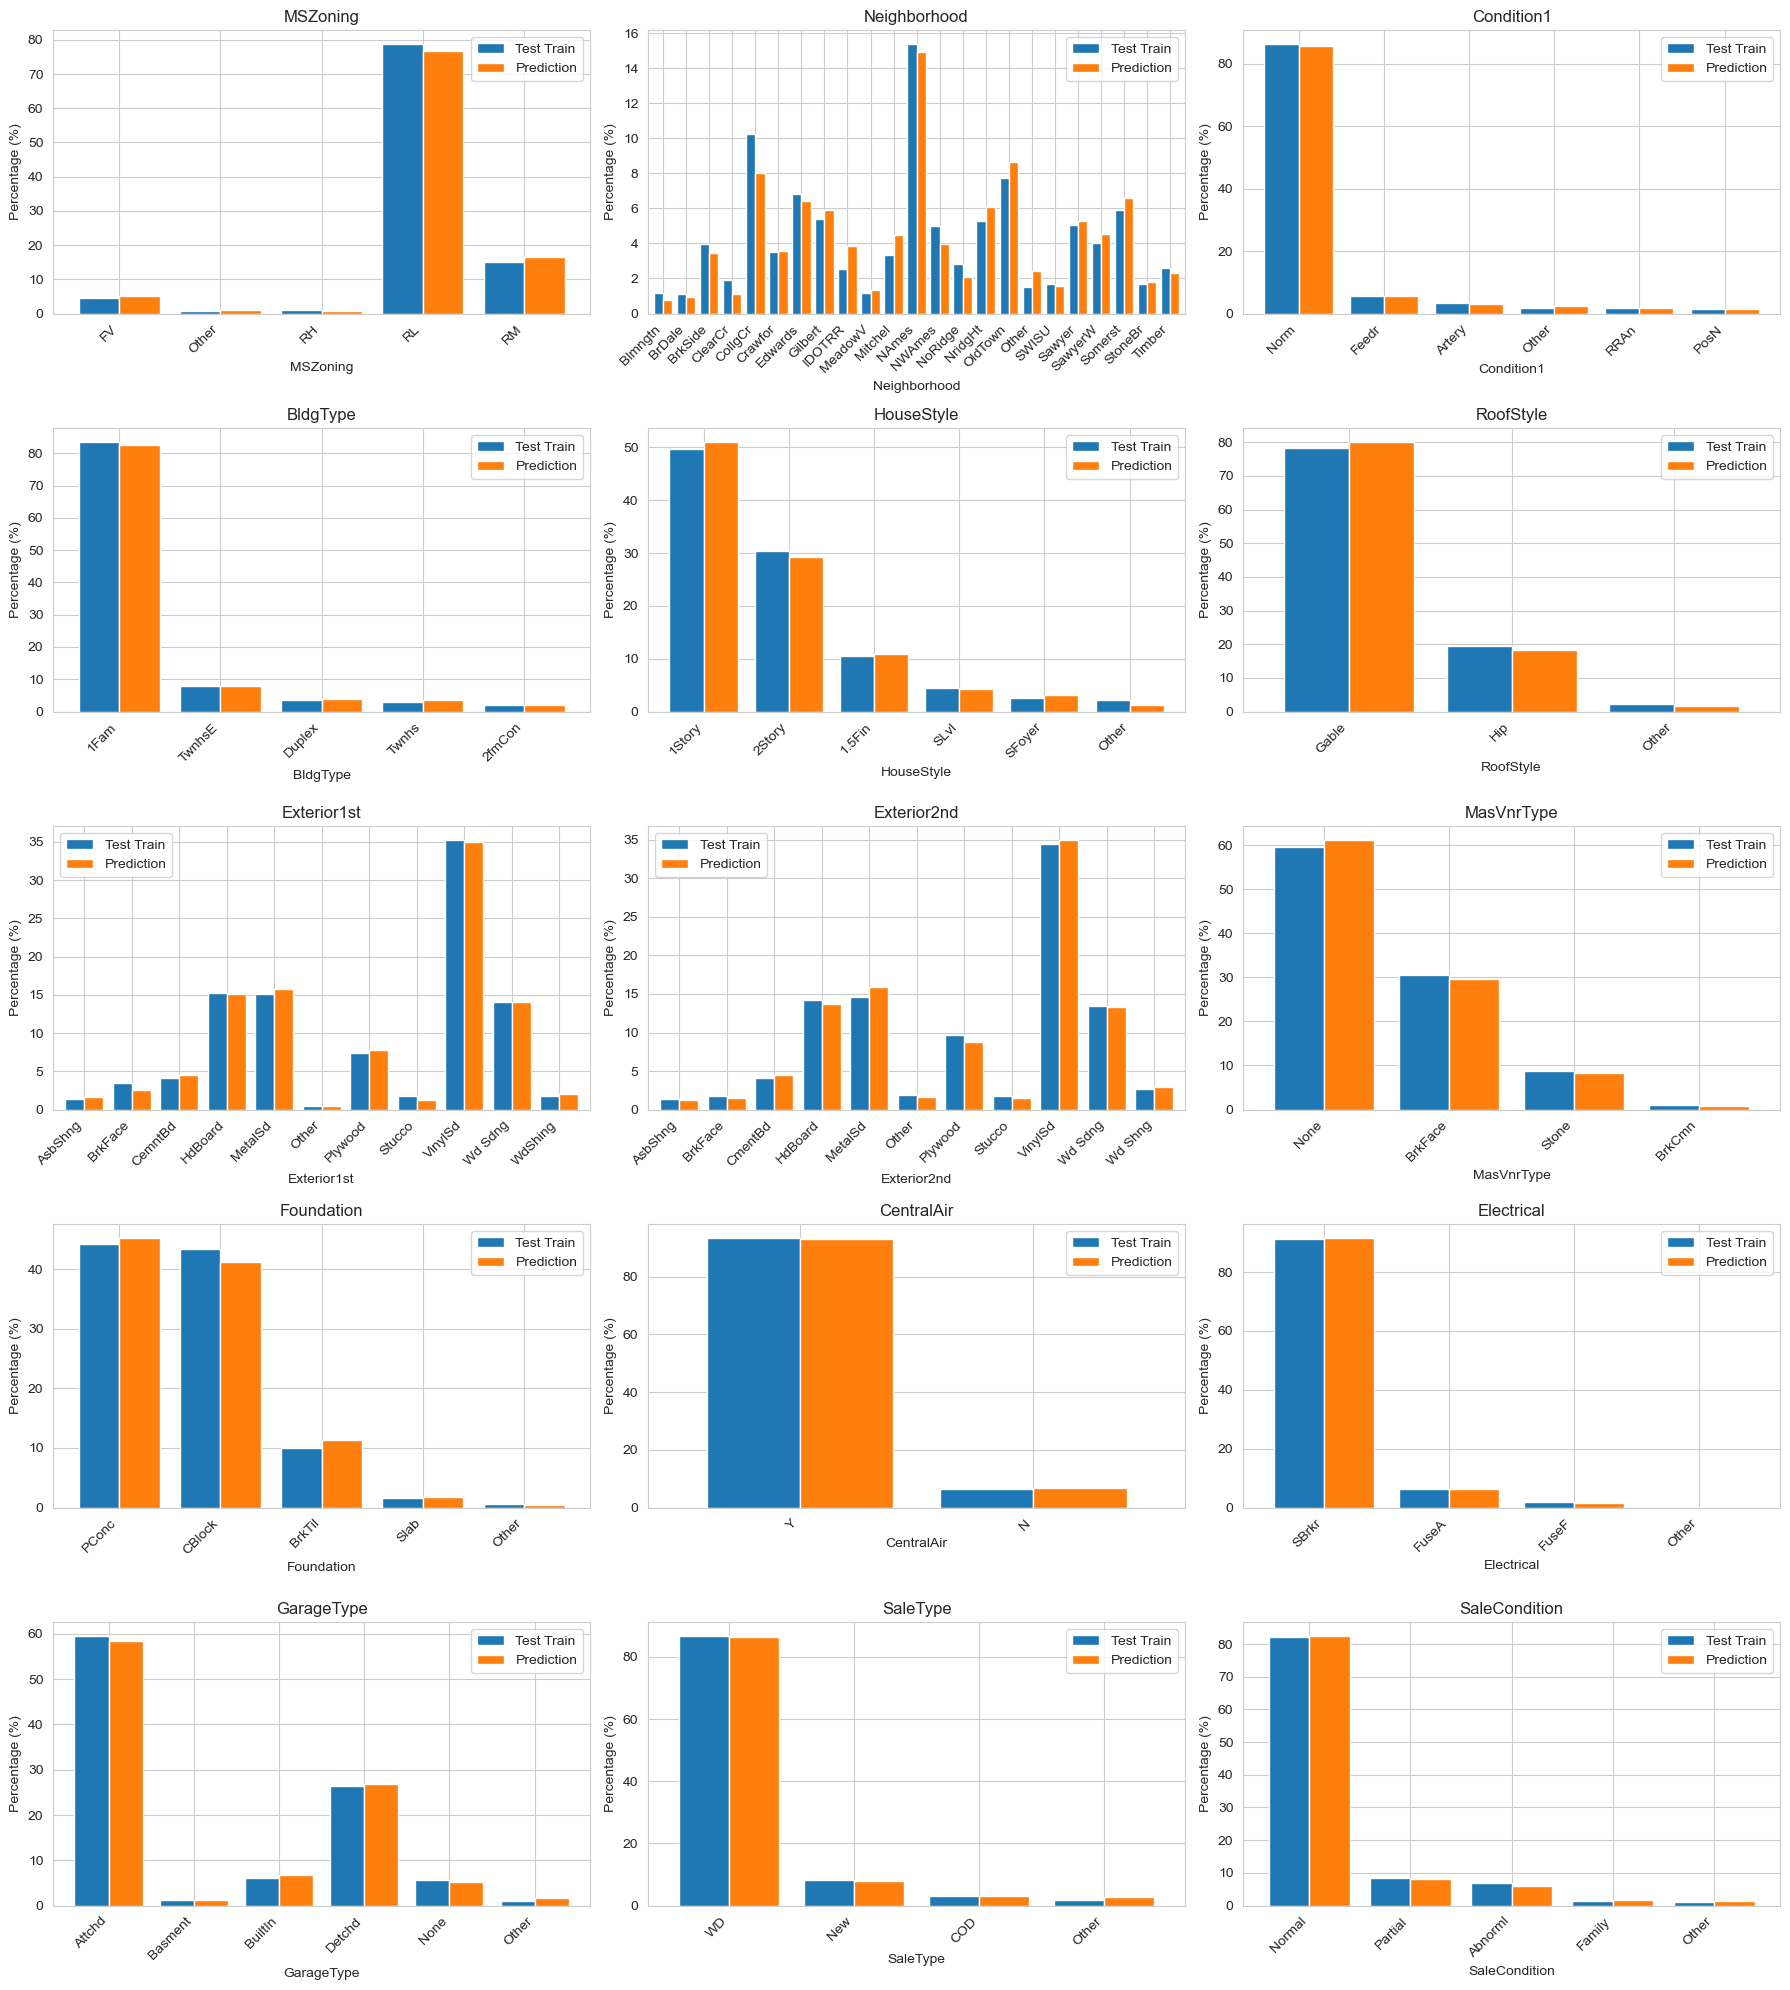

In [90]:
# Function to calculate category percentages
def category_percentage(df, feature):
    return (df[feature].value_counts(normalize=True) * 100).round(2)
# Plot comparison of distributions
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20)) 
axes = axes.flatten()
for i, feature in enumerate(nominal_features):
    ax = axes[i]
    # Combine data for a side-by-side comparison
    plot_data = pd.DataFrame({
        "Test Train": category_percentage(df_test_train, feature),
        "Prediction": category_percentage(df_prediction, feature)
    }).fillna(0) 
    plot_data.plot(kind="bar", ax=ax, width=0.8)
    ax.set_title(feature)
    ax.set_ylabel("Percentage (%)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [91]:
df_test_train.shape, df_prediction.shape


((1460, 72), (1459, 71))

*One-Hot Encoding to nominal features*

In [92]:
df_test_train = pd.get_dummies(df_test_train, columns=nominal_features, drop_first=True)
df_prediction = pd.get_dummies(df_prediction, columns=nominal_features, drop_first=True)

# Display the updated dataset shapes after encoding
df_test_train.shape, df_prediction.shape


((1460, 142), (1459, 141))

In [93]:
df_test_train.select_dtypes(include=['object']).columns

Index(['LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive'],
      dtype='object')

*Ordinal Features*

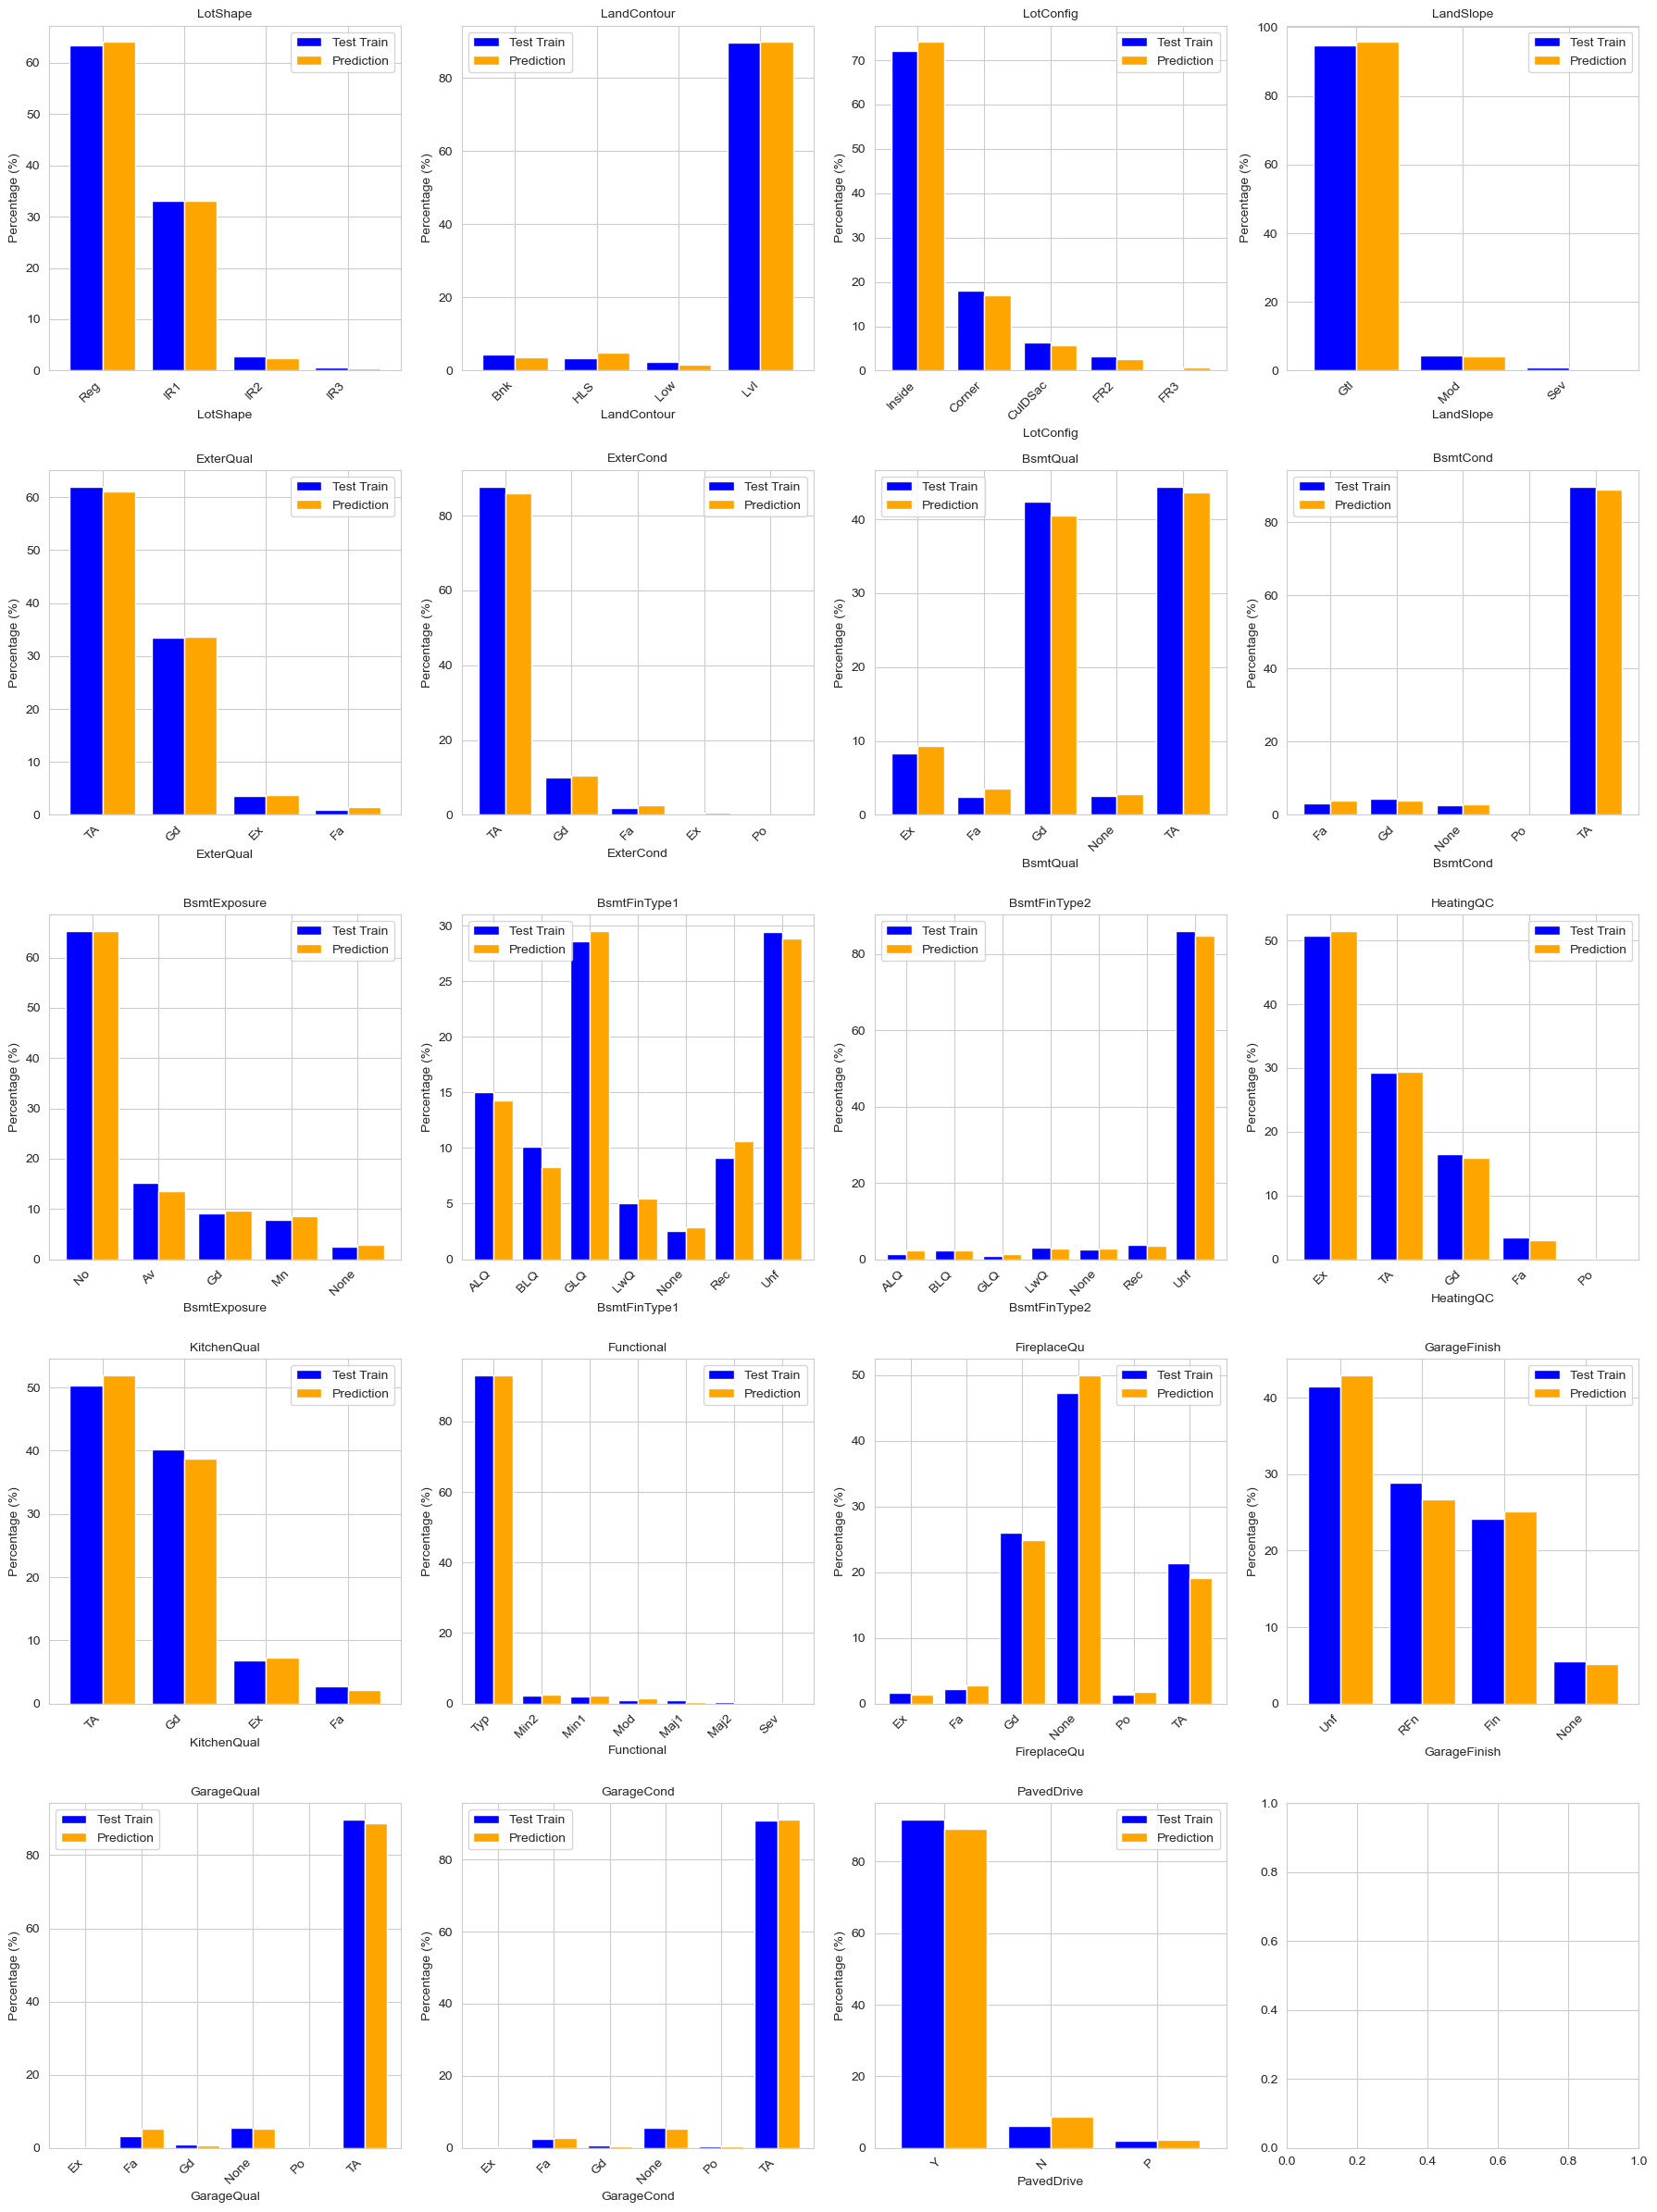

In [94]:
# List of ordinal features
ordinal_features = [
    'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'ExterQual',
    'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive'
]

# Compute percentage distributions for ordinal features in both datasets
ordinal_percentage_test_train = {feature: category_percentage(df_test_train, feature) for feature in ordinal_features}
ordinal_percentage_prediction = {feature: category_percentage(df_prediction, feature) for feature in ordinal_features}
# Plot comparison of distributions
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 24))  # 6 rows, 3 cols for 19 ordinal features
axes = axes.flatten()
for i, feature in enumerate(ordinal_features):
    ax = axes[i]
    # Combine data for a side-by-side comparison
    plot_data = pd.DataFrame({
        "Test Train": category_percentage(df_test_train, feature),
        "Prediction": category_percentage(df_prediction, feature)
    }).fillna(0)

    plot_data.plot(kind="bar", ax=ax, width=0.8, color=["blue", "orange"])
    ax.set_title(feature, fontsize=10)
    ax.set_ylabel("Percentage (%)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()


No missing categories in either dataset. Proportions are similar across both datasets. No extreme imbalance that requires merging or dropping

In [95]:
# Get unique categories for each ordinal feature in df_test_train
ordinal_categories = {feature: df_test_train[feature].dropna().unique().tolist() for feature in ordinal_features}

# Display the categories for each ordinal feature
ordinal_categories


{'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
 'LandContour': ['Lvl', 'Bnk', 'Low', 'HLS'],
 'LotConfig': ['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'],
 'LandSlope': ['Gtl', 'Mod', 'Sev'],
 'ExterQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'ExterCond': ['TA', 'Gd', 'Fa', 'Po', 'Ex'],
 'BsmtQual': ['Gd', 'TA', 'Ex', 'None', 'Fa'],
 'BsmtCond': ['TA', 'Gd', 'None', 'Fa', 'Po'],
 'BsmtExposure': ['No', 'Gd', 'Mn', 'Av', 'None'],
 'BsmtFinType1': ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'None', 'LwQ'],
 'BsmtFinType2': ['Unf', 'BLQ', 'None', 'ALQ', 'Rec', 'LwQ', 'GLQ'],
 'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
 'KitchenQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'Functional': ['Typ', 'Min1', 'Maj1', 'Min2', 'Mod', 'Maj2', 'Sev'],
 'FireplaceQu': ['None', 'TA', 'Gd', 'Fa', 'Ex', 'Po'],
 'GarageFinish': ['RFn', 'Unf', 'Fin', 'None'],
 'GarageQual': ['TA', 'Fa', 'Gd', 'None', 'Ex', 'Po'],
 'GarageCond': ['TA', 'Fa', 'None', 'Gd', 'Po', 'Ex'],
 'PavedDrive': ['Y', 'N', 'P']}

*Ordinal Enconding*

In [96]:
ordinal_mappings = {
    "LotShape": {"Reg": 3, "IR1": 2, "IR2": 1, "IR3": 0},
    "LandContour": {"Lvl": 3, "Bnk": 2, "Low": 1, "HLS": 0},
    "LotConfig": {"Inside": 4, "FR2": 3, "Corner": 2, "CulDSac": 1, "FR3": 0},
    "LandSlope": {"Gtl": 2, "Mod": 1, "Sev": 0},
    "ExterQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1},
    "ExterCond": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "BsmtQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "None": 0},
    "BsmtCond": {"Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
    "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "None": 0},
    "BsmtFinType1": {"GLQ": 6, "ALQ": 5, "Rec": 4, "BLQ": 3, "LwQ": 2, "Unf": 1, "None": 0},
    "BsmtFinType2": {"GLQ": 6, "ALQ": 5, "Rec": 4, "BLQ": 3, "LwQ": 2, "Unf": 1, "None": 0},
    "HeatingQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "KitchenQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1},
    "Functional": {"Typ": 6, "Min1": 5, "Min2": 4, "Mod": 3, "Maj1": 2, "Maj2": 1, "Sev": 0},
    "FireplaceQu": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
    "GarageFinish": {"Fin": 3, "RFn": 2, "Unf": 1, "None": 0},
    "GarageQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
    "GarageCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0},
    "PavedDrive": {"Y": 2, "P": 1, "N": 0}
}


# Apply ordinal encoding to both datasets
for feature, mapping in ordinal_mappings.items():
    df_test_train[feature] = df_test_train[feature].map(mapping).fillna(0)
    df_prediction[feature] = df_prediction[feature].map(mapping).fillna(0)

# Verify encoding by checking unique values for a few features
encoded_check = {feature: df_test_train[feature].unique() for feature in ordinal_mappings.keys()}
encoded_check


{'LotShape': array([3, 2, 1, 0], dtype=int64),
 'LandContour': array([3, 2, 1, 0], dtype=int64),
 'LotConfig': array([4, 3, 2, 1, 0], dtype=int64),
 'LandSlope': array([2, 1, 0], dtype=int64),
 'ExterQual': array([3, 2, 4, 1], dtype=int64),
 'ExterCond': array([2, 3, 1, 0, 4], dtype=int64),
 'BsmtQual': array([3, 2, 4, 0, 1], dtype=int64),
 'BsmtCond': array([3, 4, 0, 2, 1], dtype=int64),
 'BsmtExposure': array([1, 4, 2, 3, 0], dtype=int64),
 'BsmtFinType1': array([6, 5, 1, 4, 3, 0, 2], dtype=int64),
 'BsmtFinType2': array([1, 3, 0, 5, 4, 2, 6], dtype=int64),
 'HeatingQC': array([4, 3, 2, 1, 0], dtype=int64),
 'KitchenQual': array([3, 2, 4, 1], dtype=int64),
 'Functional': array([6, 5, 2, 4, 3, 1, 0], dtype=int64),
 'FireplaceQu': array([0, 3, 4, 2, 5, 1], dtype=int64),
 'GarageFinish': array([2, 1, 3, 0], dtype=int64),
 'GarageQual': array([3, 2, 4, 0, 5, 1], dtype=int64),
 'GarageCond': array([3, 2, 0, 4, 1, 5], dtype=int64),
 'PavedDrive': array([2, 0, 1], dtype=int64)}

In [97]:
df_test_train.shape, df_prediction.shape

((1460, 142), (1459, 141))

In [98]:
df_test_train.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [99]:
'''
df_test_train_path = "df_test_train_encoded.csv"
df_prediction_path = "df_prediction_encoded.csv"

# Save the processed datasets as CSV files
df_test_train.to_csv(df_test_train_path, index=False)
df_prediction.to_csv(df_prediction_path, index=False)
'''

'\ndf_test_train_path = "df_test_train_encoded.csv"\ndf_prediction_path = "df_prediction_encoded.csv"\n\n# Save the processed datasets as CSV files\ndf_test_train.to_csv(df_test_train_path, index=False)\ndf_prediction.to_csv(df_prediction_path, index=False)\n'

In [100]:
'''
df_test_train_encoded=df_test_train.copy()
df_prediction_encoded=df_prediction.copy()
'''

'\ndf_test_train_encoded=df_test_train.copy()\ndf_prediction_encoded=df_prediction.copy()\n'

In [101]:
#df_test_train_encoded.shape, df_prediction_encoded.shape

In [102]:
#Age-Based Features 
def add_age_features(df):
    df = df.copy()
    df["AgeOfHouse"] = df["YrSold"] - df["YearBuilt"]
    df["YearsSinceRemodel"] = df["YrSold"] - df["YearRemodAdd"]
    df["GarageAge"] = df["YrSold"] - df["GarageYrBlt"]
    
    # Drop original year-related columns
    df.drop(columns=["YrSold", "YearBuilt", "YearRemodAdd", "GarageYrBlt"], inplace=True, errors='ignore')
    
    return df

df_test_train = add_age_features(df_test_train)
df_prediction = add_age_features(df_prediction)

print(df_test_train.shape, df_prediction.shape)

#Total Square Footage Features 

def add_total_sqft_features(df):
    df = df.copy()
    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
    return df

df_test_train = add_total_sqft_features(df_test_train)
df_prediction = add_total_sqft_features(df_prediction)



df_test_train.shape, df_prediction.shape


(1460, 141) (1459, 140)


((1460, 142), (1459, 141))

In [103]:
# Convert all numerical columns to float32 for consistency
def convert_to_float32(df):
    for col in df.select_dtypes(include=["int64", "float64"]).columns:
        df[col] = df[col].astype("float32")
    return df

# Apply conversion to both datasets
df_test_train = convert_to_float32(df_test_train)
df_prediction = convert_to_float32(df_prediction)

# Verify consistency by checking data types
df_test_train.dtypes.unique(), df_prediction.dtypes.unique()

(array([dtype('float32'), dtype('bool')], dtype=object),
 array([dtype('float32'), dtype('bool')], dtype=object))

In [104]:
df_test_train.to_csv("df_test_train_fe.csv", index=False)
df_prediction.to_csv("df_prediction_fe.csv", index=False)



In [105]:
df_test_train_fe=pd.read_csv("df_test_train_fe.csv", na_values=["NA"], keep_default_na=False)
df_prediction_fe=pd.read_csv("df_prediction_fe.csv", na_values=["NA"], keep_default_na=False)

In [106]:
print("Train: \n",missing_values_info(df_test_train_fe))
print("Test: \n",missing_values_info(df_prediction_fe))

Train: 
 Empty DataFrame
Columns: [Missing Count, Missing Percentage, Data Type]
Index: []
Test: 
 Empty DataFrame
Columns: [Missing Count, Missing Percentage, Data Type]
Index: []


# **Distribution of Numerical Features**

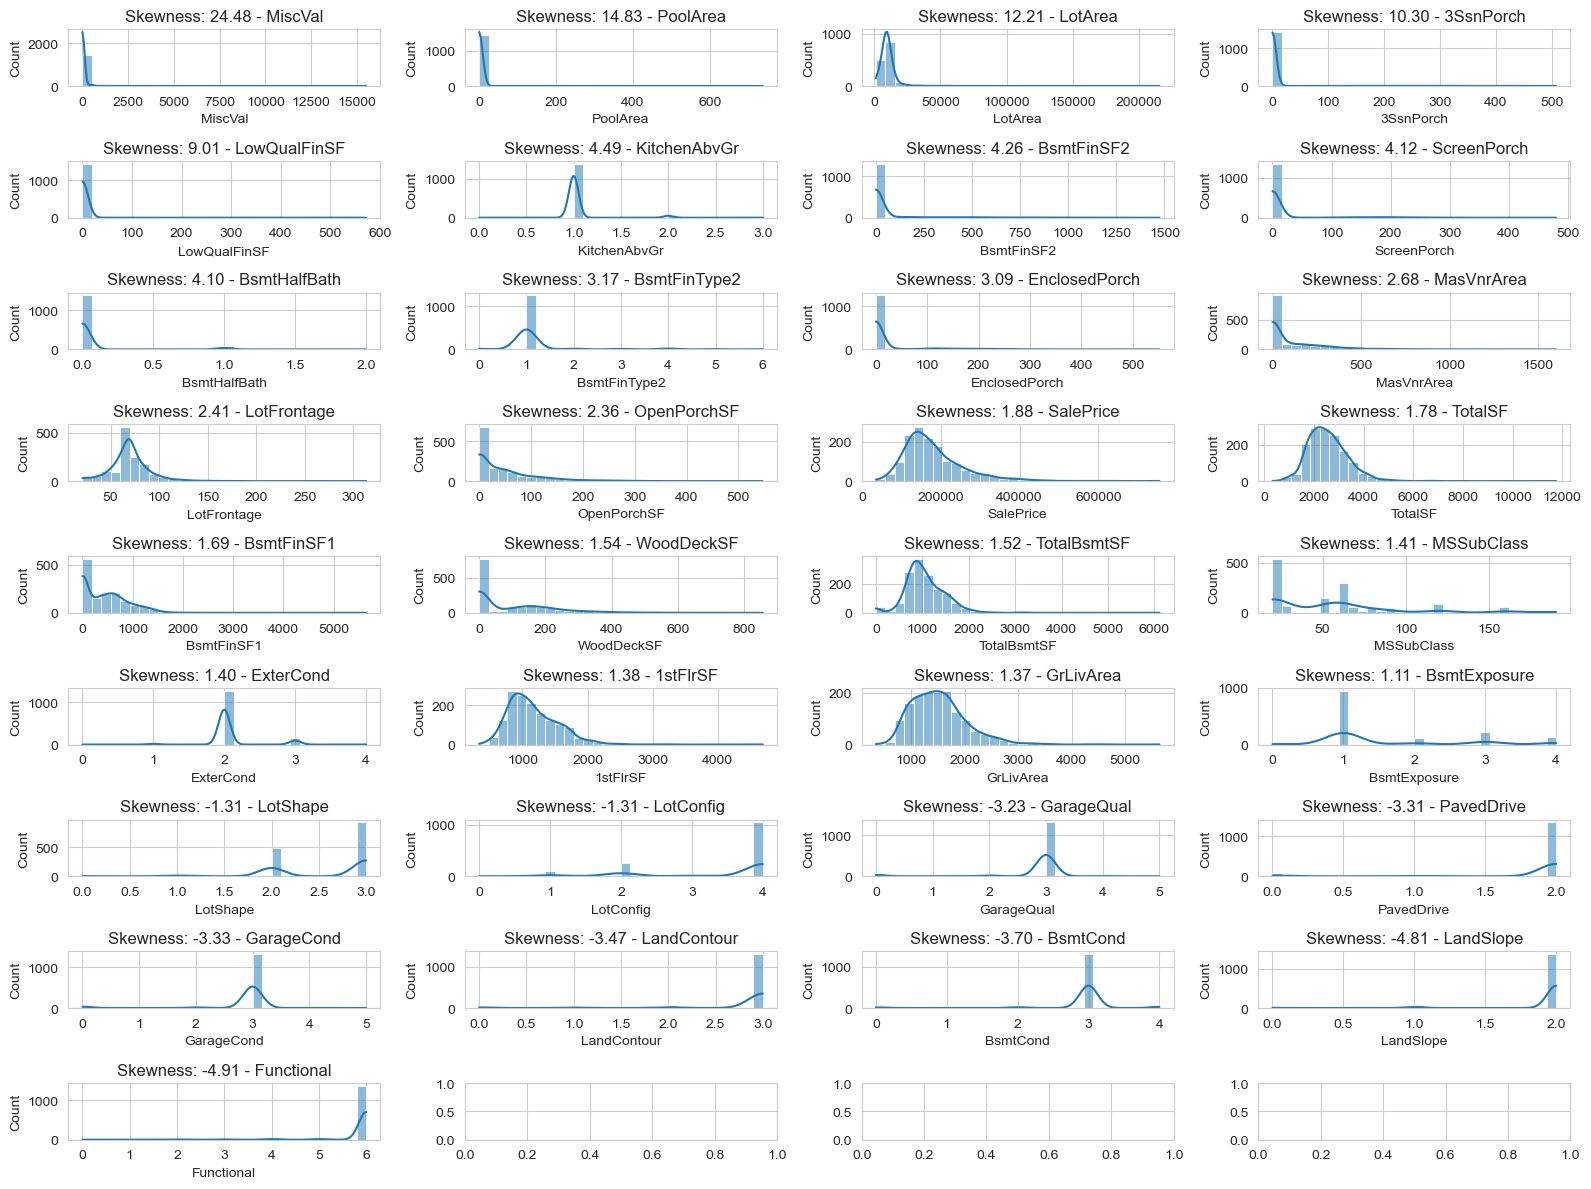

['MiscVal',
 'PoolArea',
 'LotArea',
 '3SsnPorch',
 'LowQualFinSF',
 'KitchenAbvGr',
 'BsmtFinSF2',
 'ScreenPorch',
 'BsmtHalfBath',
 'BsmtFinType2',
 'EnclosedPorch',
 'MasVnrArea',
 'LotFrontage',
 'OpenPorchSF',
 'SalePrice',
 'TotalSF',
 'BsmtFinSF1',
 'WoodDeckSF',
 'TotalBsmtSF',
 'MSSubClass',
 'ExterCond',
 '1stFlrSF',
 'GrLivArea',
 'BsmtExposure',
 'LotShape',
 'LotConfig',
 'GarageQual',
 'PavedDrive',
 'GarageCond',
 'LandContour',
 'BsmtCond',
 'LandSlope',
 'Functional']

In [107]:
# Identify numerical columns (excluding categorical and binary features)
numerical_features = df_test_train_fe.select_dtypes(include=["float32", "int64", "float64"]).columns

# Compute skewness for numerical features
skewness = df_test_train_fe[numerical_features].apply(lambda x: x.skew()).sort_values(ascending=False)

# Select features with high skewness (threshold = |1|)
highly_skewed_features = skewness[abs(skewness) > 1].index.tolist()

# Plot distribution of highly skewed features
fig, axes = plt.subplots(nrows=len(highly_skewed_features) // 4 + 1, ncols=4, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(highly_skewed_features):
    sns.histplot(df_test_train_fe[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Skewness: {skewness[feature]:.2f} - {feature}")

plt.tight_layout()
plt.show()

# Display highly skewed features
highly_skewed_features


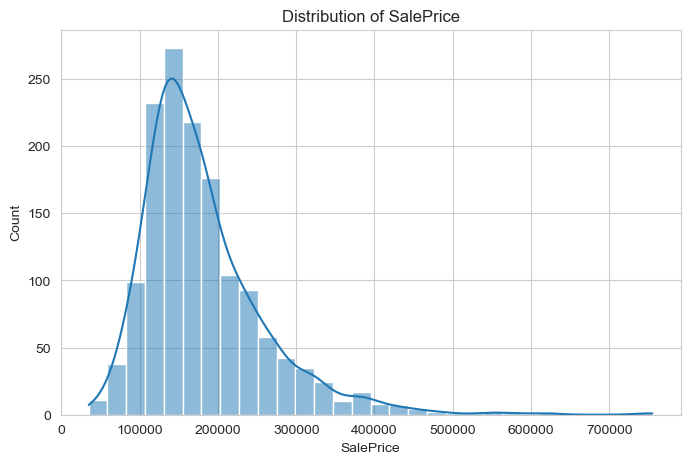

((1460, 141), (1459, 140))

In [108]:
# Drop `MiscVal` from both datasets as it is highly skewed and useless and unlikely to contribute much to predictions
df_test_train_fe.drop(columns=["MiscVal"], inplace=True, errors="ignore")
df_prediction_fe.drop(columns=["MiscVal"], inplace=True, errors="ignore")

# Plot distribution of `SalePrice` to analyze its skewness
plt.figure(figsize=(8, 5))
sns.histplot(df_test_train_fe["SalePrice"], bins=30, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

# Check dataset shapes after dropping `MiscVal`
df_test_train_fe.shape, df_prediction_fe.shape


Skip Log Transformation for Features (since XGBoost can handle skewed data).

# **Experimenting with Decision Tree Regressor**

In [113]:
# Define features (exclude 'Id' and 'SalePrice') and target variable
X = df_test_train_fe.drop(columns=["Id", "SalePrice"], errors="ignore")
y = df_test_train_fe["SalePrice"]

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Perform Grid Search with 5-fold Cross-Validation
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model parameters
best_params = grid_search.best_params_

# Train Decision Tree model with best parameters
best_dt_model = DecisionTreeRegressor(**best_params, random_state=42)
best_dt_model.fit(X_train, y_train)

# Predictions
y_pred = best_dt_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(best_params)
print("Decision Tree Model Performance:")
print(f"Best Parameters: {best_params}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Decision Tree Model Performance:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
RMSE: 36742.3292
MSE: 1349998757.0156
MAE: 23660.3186
R2 Score: 0.8240


# **Model 1 (Base Model - XGBoost Only)**

In [114]:
# Define features (exclude 'Id' and 'SalePrice') and target variable
X = df_test_train_fe.drop(columns=["Id", "SalePrice"], errors="ignore")
y = df_test_train_fe["SalePrice"]

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define XGBoost model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    "n_estimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Perform Grid Search with 5-fold Cross-Validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model parameters
best_params = grid_search.best_params_

# Train XGBoost model with best parameters
best_xgb_model = XGBRegressor(**best_params, objective="reg:squarederror", random_state=42)
best_xgb_model.fit(X_train, y_train)

# Predictions
y_pred = best_xgb_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
#best_params, rmse, mse, mae, r2
print(best_params)
print("Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Model Performance:
RMSE: 25113.9260
MSE: 630709278.4632
MAE: 16019.7946
R2 Score: 0.9178


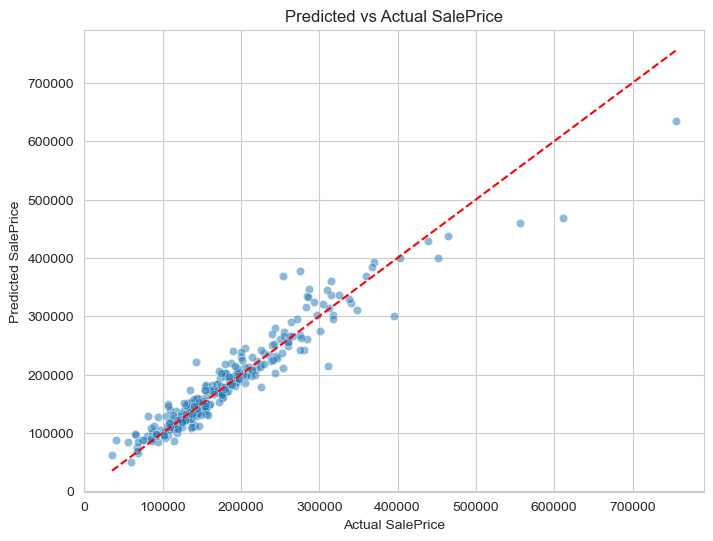

In [116]:
# Plot Predicted vs Actual SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # Perfect prediction line
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs Actual SalePrice")
plt.show()


In [117]:
SP_pred = best_xgb_model.predict(df_prediction_fe.drop(columns=["Id", "SalePrice"], errors="ignore"))
SP_pred

df_prediction_fe['SalePrice'] = SP_pred

# Convert the "Id" column to int32 data type
df_prediction_fe['Id'] = df_prediction_fe['Id'].astype('int32')

# Create a new DataFrame containing only "Id" and "SalePrice"
df_result = df_prediction_fe[['Id', 'SalePrice']]

# Save the new DataFrame to a CSV file
df_result.to_csv('predicted_sale_prices_1.csv', index=False)

In [ ]:
#!kaggle competitions submit -c house-prices-advanced-regression-techniques -f predicted_sale_prices_1.csv -m "My final submission"

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\aaliu\anaconda3\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Users\aaliu\anaconda3\Lib\site-packages\kaggle\__init__.py", line 7, in <module>
    api.authenticate()
  File "C:\Users\aaliu\anaconda3\Lib\site-packages\kaggle\api\kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\aaliu\.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


# **Model 2 (Log-Transformed SalePrice)**

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
RMSE: 25334.2611
MSE: 641824783.4390
MAE: 15024.3868
R2 Score: 0.9163


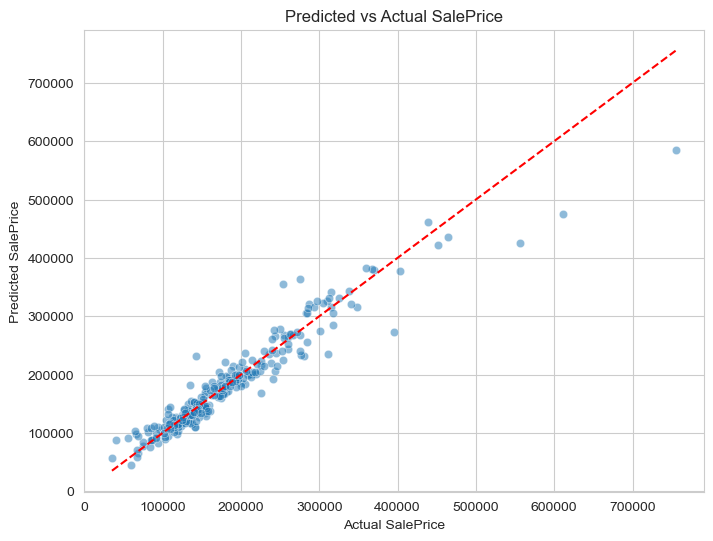

Submission file 'predicted_sale_prices_2.csv' created successfully!


In [118]:
df_test_train_fe = pd.read_csv("df_test_train_fe.csv")
df_prediction_fe = pd.read_csv("df_prediction_fe.csv")

# Apply Log Transformation to SalePrice
df_test_train_fe["SalePrice"] = np.log1p(df_test_train_fe["SalePrice"])

# Define Features and Target Variable
X = df_test_train_fe.drop(columns=["Id", "SalePrice"], errors="ignore")
y = df_test_train_fe["SalePrice"]

# Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost Model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

# Define Hyperparameter Grid for Tuning
param_grid = {
    "n_estimators": [100, 500],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get Best Model Parameters
best_params = grid_search.best_params_

# Train Model with Best Parameters
best_xgb_model = XGBRegressor(**best_params, objective="reg:squarederror", random_state=42)
best_xgb_model.fit(X_train, y_train)

# Predictions
y_pred = best_xgb_model.predict(X_test)

# Convert Log-Transformed Predictions Back
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

# Compute Performance Metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print Results
print("Best Parameters:", best_params)
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# Plot Predicted vs Actual SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.5)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color="red", linestyle="--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs Actual SalePrice")
plt.show()

# Predict Sale Prices for df_prediction_fe
SP_pred_log = best_xgb_model.predict(df_prediction_fe.drop(columns=["Id"], errors="ignore"))
SP_pred = np.expm1(SP_pred_log)  # Convert back from log scale

df_prediction_fe['SalePrice'] = SP_pred
df_prediction_fe['Id'] = df_prediction_fe['Id'].astype('int32')
df_result = df_prediction_fe[['Id', 'SalePrice']]
df_result.to_csv('predicted_sale_prices_log_sp.csv', index=False)

print("Submission file 'predicted_sale_prices_2.csv' created successfully!")


# **Model 3 (Log Transform on Skewed Features + SalePrice)**

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
RMSE: 25334.2611
MSE: 641824783.4390
MAE: 15024.3868
R2 Score: 0.9163


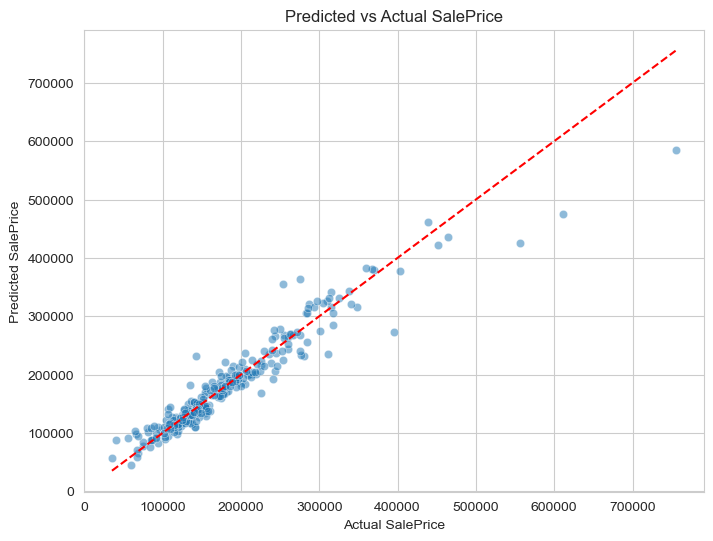

Submission file 'predicted_sale_prices_3.csv' created successfully!


In [119]:
df_test_train_fe = pd.read_csv("df_test_train_fe.csv")
df_prediction_fe = pd.read_csv("df_prediction_fe.csv")

# Identify numerical columns (excluding categorical and binary features)
numerical_features = df_test_train_fe.select_dtypes(include=["float32", "int64", "float64"]).columns

# Compute skewness for numerical features
skewness = df_test_train_fe[numerical_features].apply(lambda x: x.skew()).sort_values(ascending=False)

# Select features with high skewness (threshold = |1|)
highly_skewed_features = skewness[abs(skewness) > 1].index.tolist()

# Apply Log Transformation to SalePrice and Highly Skewed Features (only if they exist in both datasets)
df_test_train_fe["SalePrice"] = np.log1p(df_test_train_fe["SalePrice"])
common_features = [feature for feature in highly_skewed_features if feature in df_prediction_fe.columns]

for feature in common_features:
    df_test_train_fe[feature] = np.log1p(df_test_train_fe[feature])
    df_prediction_fe[feature] = np.log1p(df_prediction_fe[feature])

# Define Features and Target Variable
X = df_test_train_fe.drop(columns=["Id", "SalePrice"], errors="ignore")
y = df_test_train_fe["SalePrice"]

# Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost Model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

# Define Hyperparameter Grid for Tuning
param_grid = {
    "n_estimators": [100, 500],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get Best Model Parameters
best_params = grid_search.best_params_

# Train Model with Best Parameters
best_xgb_model = XGBRegressor(**best_params, objective="reg:squarederror", random_state=42)
best_xgb_model.fit(X_train, y_train)

# Predictions
y_pred = best_xgb_model.predict(X_test)

# Convert Log-Transformed Predictions Back
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

# Compute Performance Metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print Results
print("Best Parameters:", best_params)
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# Plot Predicted vs Actual SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.5)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color="red", linestyle="--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs Actual SalePrice")
plt.show()

# Predict Sale Prices for df_prediction_fe
SP_pred_log = best_xgb_model.predict(df_prediction_fe.drop(columns=["Id"], errors="ignore"))
SP_pred = np.expm1(SP_pred_log)  # Convert back from log scale

df_prediction_fe['SalePrice'] = SP_pred
df_prediction_fe['Id'] = df_prediction_fe['Id'].astype('int32')
df_result = df_prediction_fe[['Id', 'SalePrice']]
df_result.to_csv('predicted_sale_prices_3.csv', index=False)

print("Submission file 'predicted_sale_prices_3.csv' created successfully!")

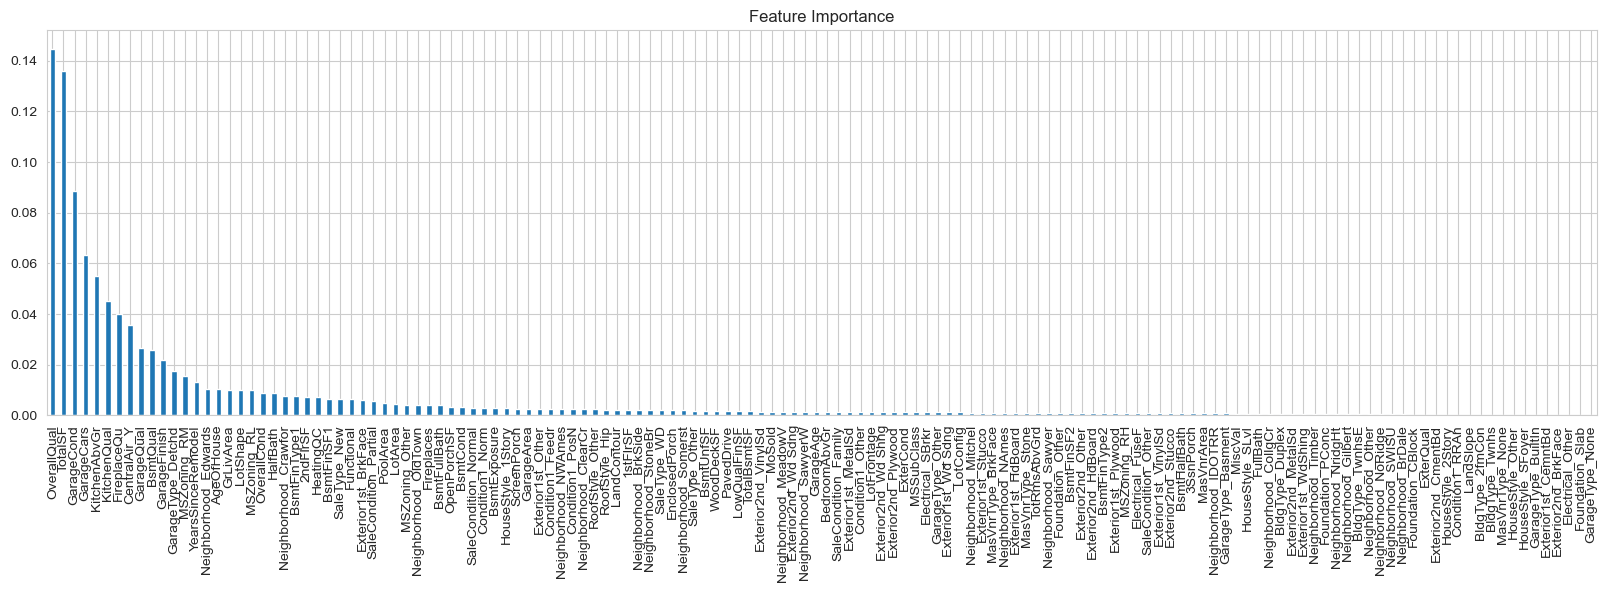

In [120]:
feature_importances = pd.Series(best_xgb_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind="bar", figsize=(20, 5))
plt.title("Feature Importance")
plt.show()

# **Model 4 (XGBoost + LightGBM Weighted Ensemble: 0.9 XGB + 0.1 LGBM)**

[I 2025-02-25 21:56:46,602] A new study created in memory with name: no-name-7e1cf4e7-5326-40e2-8b35-f8527d86e4a7
[I 2025-02-25 21:56:53,169] Trial 0 finished with value: 0.1255716804618214 and parameters: {'n_estimators': 1485, 'learning_rate': 0.02702271829641378, 'max_depth': 3, 'subsample': 0.8112091974742357, 'colsample_bytree': 0.8012719825481736, 'gamma': 0.024093046788080608, 'reg_alpha': 0.3111799448252601, 'reg_lambda': 0.23876250617139583}. Best is trial 0 with value: 0.1255716804618214.
[I 2025-02-25 21:57:03,126] Trial 1 finished with value: 0.1435618480926093 and parameters: {'n_estimators': 1616, 'learning_rate': 0.16908897134231923, 'max_depth': 7, 'subsample': 0.7521794467034429, 'colsample_bytree': 0.7753687858454635, 'gamma': 0.4769449340315847, 'reg_alpha': 0.2731091525251489, 'reg_lambda': 0.05013907913034321}. Best is trial 0 with value: 0.1255716804618214.
[I 2025-02-25 21:57:10,941] Trial 2 finished with value: 0.14342501184304934 and parameters: {'n_estimators'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4053
[LightGBM] [Info] Number of data points in the train set: 1051, number of used features: 121
[LightGBM] [Info] Start training from score 12.028758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

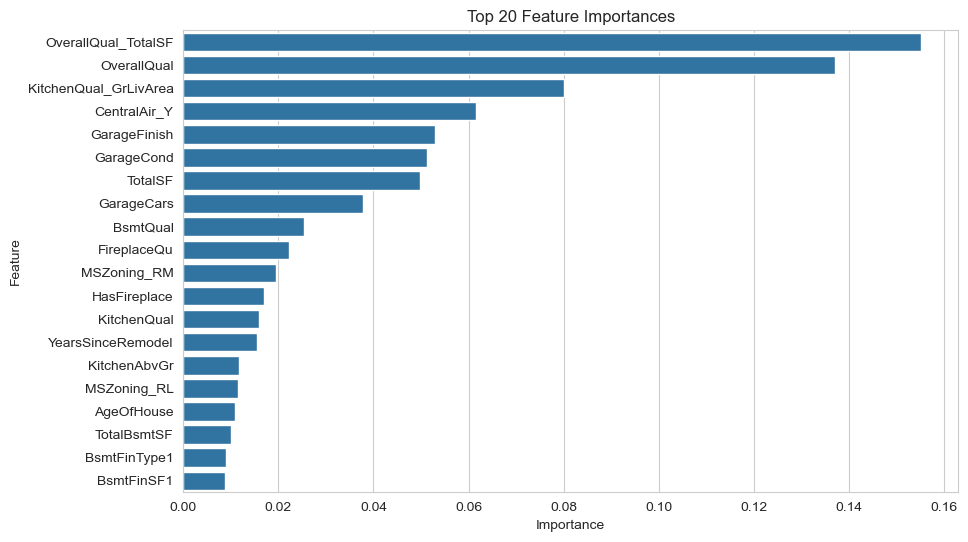

In [134]:
df_test_train_fe = pd.read_csv("df_test_train_fe.csv")
df_prediction_fe = pd.read_csv("df_prediction_fe.csv")


# TARGET TRANSFORMATION


# Apply log transformation to SalePrice
df_test_train_fe['SalePrice'] = np.log1p(df_test_train_fe['SalePrice'])


# ADVANCED FEATURE ENGINEERING


def add_advanced_features(df):
    df = df.copy()
    
    # Bathroom features
    df['TotalBath'] = df['FullBath'] + 0.5*df['HalfBath']
    df['BsmtBath'] = df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    
    # Quality interactions
    df['OverallQual_TotalSF'] = df['OverallQual'] * df['TotalSF']
    df['KitchenQual_GrLivArea'] = df['KitchenQual'] * df['GrLivArea']
    
    # Age interactions
    df['Age_OverallQual'] = df['AgeOfHouse'] * df['OverallQual']
    
    # External features
    df['HasPool'] = np.where(df['PoolArea'] > 0, 1, 0).astype('float32')
    df['HasFireplace'] = np.where(df['Fireplaces'] > 0, 1, 0).astype('float32')
    
    return df

# Apply to both datasets
df_test_train_fe = add_advanced_features(df_test_train_fe)
df_prediction_fe = add_advanced_features(df_prediction_fe)


# DATA PREPARATION


# Prepare features and target
X = df_test_train_fe.drop(columns=['Id', 'SalePrice'])
y = df_test_train_fe['SalePrice']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# HYPERPARAMETER OPTIMIZATION


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    model = XGBRegressor(**params, objective='reg:squarederror', random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = -cross_val_score(model, X_train, y_train, cv=kfold, 
                            scoring='neg_mean_squared_error')
    return np.sqrt(scores.mean())

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # Reduce trials for faster execution

best_params = study.best_params


# MODEL TRAINING


# Final XGBoost model with early stopping
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

xgb_model = XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=50
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# LightGBM model
lgb_params = {
    'n_estimators': 1500,
    'learning_rate': 0.05,
    'num_leaves': 30,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42
}

lgb_model = LGBMRegressor(**lgb_params)
lgb_model.fit(X_train, y_train)


# ENSEMBLE & EVALUATION


# Generate predictions
xgb_pred = xgb_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)
ensemble_pred = 0.7*xgb_pred + 0.3*lgb_pred

# Convert back from log scale
y_test_exp = np.expm1(y_test)
ensemble_pred_exp = np.expm1(ensemble_pred)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_exp, ensemble_pred_exp))
r2 = r2_score(y_test_exp, ensemble_pred_exp)

print(f'\n{"-"*40}')
print(f'Ensemble RMSE: {rmse:.4f}')
print(f'Ensemble R²: {r2:.4f}')
print(f'{"-"*40}\n')


# FEATURE IMPORTANCE


# Plot feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 20 Feature Importances')
plt.show()


# FINAL PREDICTIONS

# Prepare test data
test_ids = df_prediction_fe['Id']
X_final_test = df_prediction_fe.drop(columns=['Id', 'SalePrice'], errors='ignore')

# Align columns with training data
X_final_test = X_final_test.reindex(columns=X.columns, fill_value=0)

# Generate final predictions
final_xgb_pred = xgb_model.predict(X_final_test)
final_lgb_pred = lgb_model.predict(X_final_test)
final_ensemble = 0.9*final_xgb_pred + 0.1*final_lgb_pred

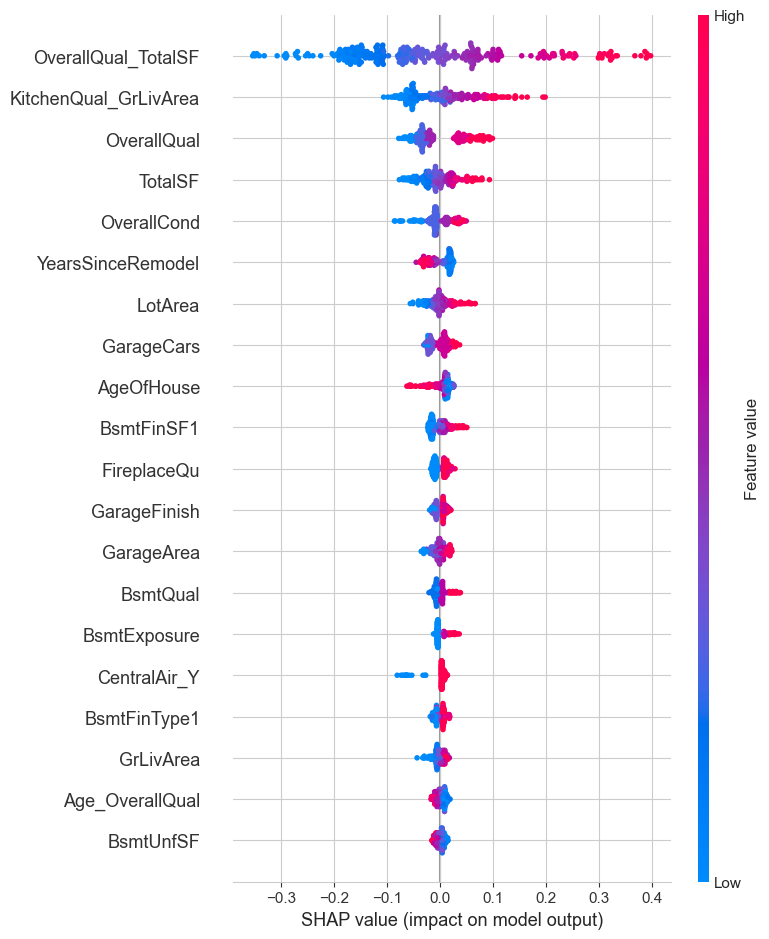

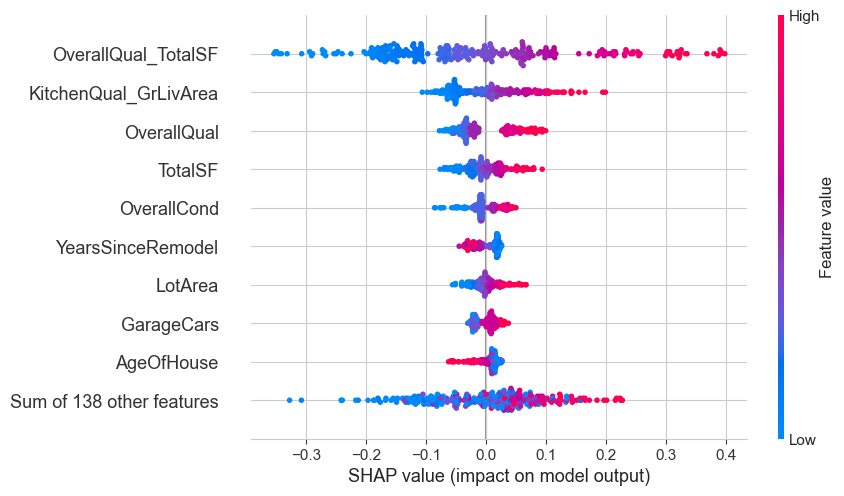

In [ ]:

# Calculate SHAP values
shap_values = explainer(X_test)

# Summary plot (Feature Importance)
shap.summary_plot(shap_values, X_test)

# Beeswarm plot
shap.plots.beeswarm(shap_values)


In [139]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': np.expm1(final_ensemble)
})


submission["Id"] = submission["Id"].astype(np.int32)

# Save results
submission.to_csv('final_submission_4.csv', index=False)
print('Submission file created successfully!')

Submission file created successfully!


In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f final_submission_4.csv -m "My final submission"

# **Model 5 (XGBoost + LightGBM Weighted Ensemble: 0.7 XGB + 0.3 LGBM)**

[I 2025-02-25 21:47:16,597] A new study created in memory with name: no-name-7a169d03-c89b-481f-91b9-c281c9891288
[I 2025-02-25 21:47:21,220] Trial 0 finished with value: 0.13959783858940153 and parameters: {'n_estimators': 890, 'learning_rate': 0.1050531087681085, 'max_depth': 8, 'subsample': 0.9516982867246123, 'colsample_bytree': 0.7717182743206263, 'gamma': 0.12243161242817091, 'reg_alpha': 0.5529150103411447, 'reg_lambda': 0.8988056275291207}. Best is trial 0 with value: 0.13959783858940153.
[I 2025-02-25 21:47:27,577] Trial 1 finished with value: 0.1423633628489218 and parameters: {'n_estimators': 854, 'learning_rate': 0.08593045488547087, 'max_depth': 8, 'subsample': 0.9734874477900903, 'colsample_bytree': 0.7464620181545243, 'gamma': 0.2548644280283219, 'reg_alpha': 0.5560289756117677, 'reg_lambda': 0.7348382546338643}. Best is trial 0 with value: 0.13959783858940153.
[I 2025-02-25 21:47:38,621] Trial 2 finished with value: 0.13760953119808728 and parameters: {'n_estimators': 1

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4053
[LightGBM] [Info] Number of data points in the train set: 1051, number of used features: 121
[LightGBM] [Info] Start training from score 12.028758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

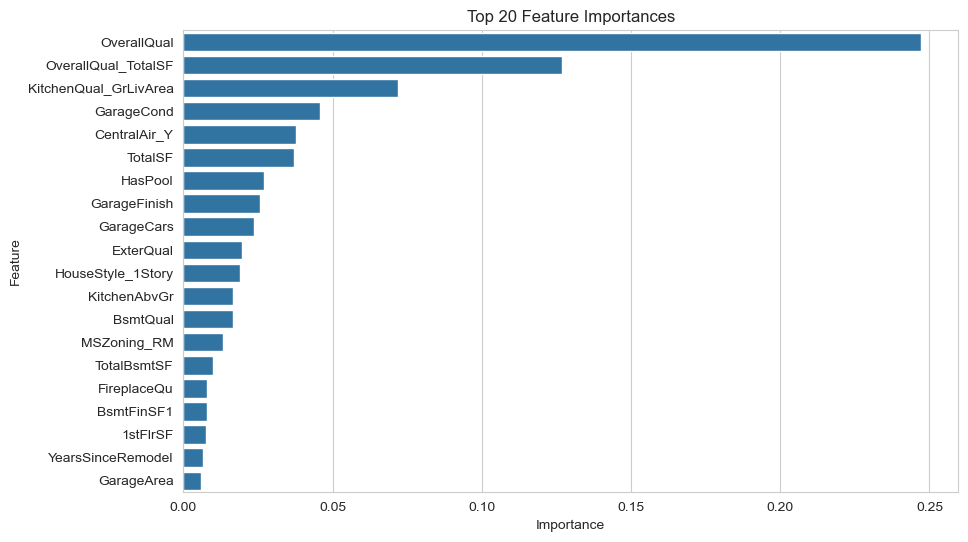

In [126]:
df_test_train_fe = pd.read_csv("df_test_train_fe.csv")
df_prediction_fe = pd.read_csv("df_prediction_fe.csv")



# TARGET TRANSFORMATION


# Apply log transformation to SalePrice
df_test_train_fe['SalePrice'] = np.log1p(df_test_train_fe['SalePrice'])


# ADVANCED FEATURE ENGINEERING

def add_advanced_features(df):
    df = df.copy()
    
    # Bathroom features
    df['TotalBath'] = df['FullBath'] + 0.5*df['HalfBath']
    df['BsmtBath'] = df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    
    # Quality interactions
    df['OverallQual_TotalSF'] = df['OverallQual'] * df['TotalSF']
    df['KitchenQual_GrLivArea'] = df['KitchenQual'] * df['GrLivArea']
    
    # Age interactions
    df['Age_OverallQual'] = df['AgeOfHouse'] * df['OverallQual']
    
    # External features
    df['HasPool'] = np.where(df['PoolArea'] > 0, 1, 0).astype('float32')
    df['HasFireplace'] = np.where(df['Fireplaces'] > 0, 1, 0).astype('float32')
    
    return df

# Apply to both datasets
df_test_train_fe = add_advanced_features(df_test_train_fe)
df_prediction_fe = add_advanced_features(df_prediction_fe)


# DATA PREPARATION


# Prepare features and target
X = df_test_train_fe.drop(columns=['Id', 'SalePrice'])
y = df_test_train_fe['SalePrice']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# HYPERPARAMETER OPTIMIZATION


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    model = XGBRegressor(**params, objective='reg:squarederror', random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = -cross_val_score(model, X_train, y_train, cv=kfold, 
                            scoring='neg_mean_squared_error')
    return np.sqrt(scores.mean())

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # Reduce trials for faster execution

best_params = study.best_params


# MODEL TRAINING

# Final XGBoost model with early stopping
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

xgb_model = XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=50
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# LightGBM model
lgb_params = {
    'n_estimators': 1500,
    'learning_rate': 0.05,
    'num_leaves': 30,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42
}

lgb_model = LGBMRegressor(**lgb_params)
lgb_model.fit(X_train, y_train)


# ENSEMBLE & EVALUATION


# Generate predictions
xgb_pred = xgb_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)
ensemble_pred = 0.7*xgb_pred + 0.3*lgb_pred

# Convert back from log scale
y_test_exp = np.expm1(y_test)
ensemble_pred_exp = np.expm1(ensemble_pred)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_exp, ensemble_pred_exp))
r2 = r2_score(y_test_exp, ensemble_pred_exp)

print(f'\n{"-"*40}')
print(f'Ensemble RMSE: {rmse:.4f}')
print(f'Ensemble R²: {r2:.4f}')
print(f'{"-"*40}\n')


# FEATURE IMPORTANCE


# Plot feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 20 Feature Importances')
plt.show()


# FINAL PREDICTIONS


# Prepare test data
test_ids = df_prediction_fe['Id']
X_final_test = df_prediction_fe.drop(columns=['Id', 'SalePrice'], errors='ignore')

# Align columns with training data
X_final_test = X_final_test.reindex(columns=X.columns, fill_value=0)

# Generate final predictions
final_xgb_pred = xgb_model.predict(X_final_test)
final_lgb_pred = lgb_model.predict(X_final_test)
final_ensemble = 0.7*final_xgb_pred + 0.3*final_lgb_pred



In [127]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': np.expm1(final_ensemble)
})
submission["Id"] = submission["Id"].astype(np.int32)
# Save results
submission.to_csv('final_submission_5.csv', index=False)
print('Submission file created successfully!')

Submission file created successfully!


# **Model 6 (Stacking Ensemble: XGBoost + LightGBM + CatBoost)**

In [3]:

df_train = pd.read_csv("df_test_train_fe.csv")
df_test = pd.read_csv("df_prediction_fe.csv")



#HELPER FUNCTIONS

def remove_outliers(df, column, upper_quantile=0.99):
    """
    Removes rows where `column` exceeds the specified upper quantile.
    (Alternatively, you could 'cap' the values instead of removing.)
    """
    cutoff = df[column].quantile(upper_quantile)
    df = df[df[column] < cutoff].copy()
    return df

def drop_highly_correlated(df, threshold=0.9):
    """
    Drops features that are highly correlated (absolute correlation > threshold).
    Returns the reduced DataFrame and the list of dropped columns.
    """
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]
    df = df.drop(columns=to_drop, errors='ignore')
    return df, to_drop

def add_advanced_features(df):
    """
    Example advanced feature engineering. 
    Adjust for your dataset's column names as appropriate.
    """
    df = df.copy()
    
    # Basic numeric transformations
    df['TotalBath'] = df['FullBath'] + 0.5*df['HalfBath']
    df['BsmtBath'] = df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    
    # Feature interactions
    df['OverallQual_TotalSF'] = df['OverallQual'] * df['TotalSF']
    df['KitchenQual_GrLivArea'] = df['KitchenQual'] * df['GrLivArea']
    df['Age_OverallQual'] = df['AgeOfHouse'] * df['OverallQual']
    
    # Binary flags
    df['HasPool'] = np.where(df['PoolArea'] > 0, 1, 0).astype('float32')
    df['HasFireplace'] = np.where(df['Fireplaces'] > 0, 1, 0).astype('float32')
    
    return df



In [4]:



#FEATURE ENGINEERING & CLEANING ON TRAIN SET

# (A) Convert SalePrice to log scale
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

# (B) Outlier Removal (Example on SalePrice)
df_train = remove_outliers(df_train, 'SalePrice', upper_quantile=0.99)

# (C) Advanced Feature Engineering
df_train = add_advanced_features(df_train)

# (D) Prepare X, y
X = df_train.drop(columns=['Id', 'SalePrice'], errors='ignore')
y = df_train['SalePrice']

# (E) Drop Highly Correlated Features
X, dropped_cols = drop_highly_correlated(X, threshold=0.9)
print("Dropped features due to correlation:", dropped_cols)

# (F) Example of power transform on known skewed columns
skewed_cols = ['TotalSF', 'GrLivArea']  # Example columns
pt = PowerTransformer(method='yeo-johnson', standardize=False)
X[skewed_cols] = pt.fit_transform(X[skewed_cols])

# (G) Polynomial features for selected numeric columns
poly_cols = ['OverallQual', 'GarageCars']  # example columns to create interactions
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_arr = poly.fit_transform(X[poly_cols])
X_poly_df = pd.DataFrame(X_poly_arr, columns=poly.get_feature_names_out(poly_cols))

# Remove original columns and add polynomial features
X.drop(columns=poly_cols, inplace=True)
X = pd.concat([X.reset_index(drop=True), X_poly_df.reset_index(drop=True)], axis=1)

Dropped features due to correlation: ['GarageCond', 'Exterior2nd_CmentBd', 'Exterior2nd_MetalSd', 'Exterior2nd_VinylSd', 'GarageType_None', 'SaleCondition_Partial', 'TotalBath', 'BsmtBath', 'OverallQual_TotalSF', 'Age_OverallQual', 'HasPool', 'HasFireplace']


In [5]:
#SPLIT DATA INTO TRAIN/TEST FOR FINAL EVALUATION
# We'll use 20% of the data for a final test set (X_test_final, y_test_final).
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
#REPEATED K-FOLD FOR HYPERPARAMETER TUNING WITH OPTUNA
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)


In [ ]:


#XGB Hyperparameter Tuning

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    model = XGBRegressor(**params, objective='reg:squarederror', random_state=42)
    scores = -cross_val_score(
        model, X_train_full, y_train_full, 
        cv=rkf, scoring='neg_mean_squared_error'
    )
    return np.sqrt(scores.mean())

xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_objective, n_trials=15)  # Increase n_trials if you want more thorough search
best_xgb_params = xgb_study.best_params
print("Best XGB Params:", best_xgb_params)


[I 2025-02-25 04:03:49,371] A new study created in memory with name: no-name-4e803c78-b7a7-4144-a0f9-dfbc1cbd9694
[I 2025-02-25 04:03:58,573] Trial 0 finished with value: 0.1364804622578939 and parameters: {'n_estimators': 637, 'learning_rate': 0.010228044347031024, 'max_depth': 7, 'subsample': 0.6696578584556149, 'colsample_bytree': 0.6808600235581075, 'gamma': 0.1980110796863988, 'reg_alpha': 0.2415560975315023, 'reg_lambda': 0.2427929842820543}. Best is trial 0 with value: 0.1364804622578939.
[I 2025-02-25 04:04:07,019] Trial 1 finished with value: 0.13835052045857618 and parameters: {'n_estimators': 735, 'learning_rate': 0.04424982857873676, 'max_depth': 8, 'subsample': 0.992084359472651, 'colsample_bytree': 0.6610127331457115, 'gamma': 0.1592259666399658, 'reg_alpha': 0.20452446447326567, 'reg_lambda': 0.7599712363450624}. Best is trial 0 with value: 0.1364804622578939.
[I 2025-02-25 04:04:19,694] Trial 2 finished with value: 0.13796213536564453 and parameters: {'n_estimators': 90

Best XGB Params: {'n_estimators': 723, 'learning_rate': 0.08670226834490061, 'max_depth': 8, 'subsample': 0.6393681992214408, 'colsample_bytree': 0.632507479693407, 'gamma': 0.022865813130938994, 'reg_alpha': 0.317529030434924, 'reg_lambda': 0.3332209538660855}


In [7]:
best_xgb_params = {'n_estimators': 723, 'learning_rate': 0.08670226834490061, 'max_depth': 8, 'subsample': 0.6393681992214408, 'colsample_bytree': 0.632507479693407, 'gamma': 0.022865813130938994, 'reg_alpha': 0.317529030434924, 'reg_lambda': 0.3332209538660855}

In [ ]:

# LGB Hyperparameter Tuning
def lgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    model = LGBMRegressor(**params, random_state=42)
    scores = -cross_val_score(
        model, X_train_full, y_train_full, 
        cv=rkf, scoring='neg_mean_squared_error'
    )
    return np.sqrt(scores.mean())

lgb_study = optuna.create_study(direction='minimize')
lgb_study.optimize(lgb_objective, n_trials=15)
best_lgb_params = lgb_study.best_params
print("Best LGB Params:", best_lgb_params)


'\n# -----------------------------------------------------------------------------\n# 5B. LGB Hyperparameter Tuning\n# -----------------------------------------------------------------------------\ndef lgb_objective(trial):\n    params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 500, 1500),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.005, 0.2),\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 10, 100),\n        \'max_depth\': trial.suggest_int(\'max_depth\', -1, 15),\n        \'min_child_samples\': trial.suggest_int(\'min_child_samples\', 5, 100),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.6, 1.0),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.6, 1.0),\n        \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 0.0, 1.0),\n        \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 0.0, 1.0)\n    }\n    model = LGBMRegressor(**params, random_state=42)\n    scores = -cross_val_score(\

In [8]:
best_lgb_params = {'n_estimators': 1032, 'learning_rate': 0.1752716945247709, 'num_leaves': 58, 'max_depth': 1, 'min_child_samples': 35, 'subsample': 0.9965315180355165, 'colsample_bytree': 0.9079016031354282, 'reg_alpha': 0.5171528075349805, 'reg_lambda': 0.2377497766803165}

In [95]:

# -----------------------------------------------------------------------------
# 5C. CatBoost Hyperparameter Tuning
# -----------------------------------------------------------------------------
def cat_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'depth': trial.suggest_int('depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True)
    }
    model = CatBoostRegressor(
        **params,
        loss_function='RMSE',
        random_seed=42,
        verbose=False
    )
    scores = -cross_val_score(
        model, X_train_full, y_train_full, 
        cv=rkf, scoring='neg_mean_squared_error'
    )
    return np.sqrt(scores.mean())

cat_study = optuna.create_study(direction='minimize')
cat_study.optimize(cat_objective, n_trials=15)
best_cat_params = cat_study.best_params
print("Best CatBoost Params:", best_cat_params)

[I 2025-02-25 04:09:48,167] A new study created in memory with name: no-name-675b3d61-26bb-444f-a071-c6a01708fdf3
[I 2025-02-25 04:10:11,180] Trial 0 finished with value: 0.12448267392333147 and parameters: {'iterations': 1057, 'learning_rate': 0.010855584533931071, 'depth': 4, 'subsample': 0.9725045490904437, 'colsample_bylevel': 0.9534209263519108, 'l2_leaf_reg': 0.3761593107962903}. Best is trial 0 with value: 0.12448267392333147.
[I 2025-02-25 04:10:43,652] Trial 1 finished with value: 0.1233810038209781 and parameters: {'iterations': 1478, 'learning_rate': 0.0940139849469048, 'depth': 4, 'subsample': 0.746977499219779, 'colsample_bylevel': 0.8403673961485484, 'l2_leaf_reg': 3.304630572220573}. Best is trial 1 with value: 0.1233810038209781.
[I 2025-02-25 04:19:17,052] Trial 2 finished with value: 0.1306228434175881 and parameters: {'iterations': 1417, 'learning_rate': 0.16404058120445333, 'depth': 10, 'subsample': 0.7790400824953174, 'colsample_bylevel': 0.8102423971823893, 'l2_le

Best CatBoost Params: {'iterations': 748, 'learning_rate': 0.03335766147494279, 'depth': 5, 'subsample': 0.602611182719294, 'colsample_bylevel': 0.6140043339256094, 'l2_leaf_reg': 0.010770013981956964}


In [9]:
best_cat_params = {'iterations': 748, 'learning_rate': 0.03335766147494279, 'depth': 5, 'subsample': 0.602611182719294, 'colsample_bylevel': 0.6140043339256094, 'l2_leaf_reg': 0.010770013981956964}

In [10]:

#TRAIN FINAL MODELS (NO EARLY STOPPING => COMPATIBLE WITH STACKING)


xgb_model = XGBRegressor(
    **best_xgb_params,
    objective='reg:squarederror',
    random_state=42
)
xgb_model.fit(X_train_full, y_train_full)

lgb_model = LGBMRegressor(
    **best_lgb_params,
    random_state=42
)
lgb_model.fit(X_train_full, y_train_full)

cat_model = CatBoostRegressor(
    **best_cat_params,
    loss_function='RMSE',
    random_seed=42,
    verbose=False
)
cat_model.fit(X_train_full, y_train_full)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 101
[LightGBM] [Info] Start training from score 12.024828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [11]:

#MODEL EVALUATION ON X_test_final

xgb_preds = xgb_model.predict(X_test_final)
lgb_preds = lgb_model.predict(X_test_final)
cat_preds = cat_model.predict(X_test_final)

y_test_final_exp = np.expm1(y_test_final)  # Real scale target


# Weighted Ensemble (Search for best weights)

weights = np.linspace(0, 1, 6)  # e.g., 0,0.2,0.4,0.6,0.8,1
best_rmse = float('inf')
best_combo = (None, None, None)

for w1 in weights:
    for w2 in weights:
        w3 = 1 - w1 - w2
        # Must ensure w3 >= 0 => skip negative combos
        if w3 < 0:
            continue
        ensemble = w1*xgb_preds + w2*lgb_preds + w3*cat_preds
        ensemble_exp = np.expm1(ensemble)
        rmse_ens = np.sqrt(mean_squared_error(y_test_final_exp, ensemble_exp))
        if rmse_ens < best_rmse:
            best_rmse = rmse_ens
            best_combo = (w1, w2, w3)

print(f"Best Weighted Combo for (XGB,LGB,Cat) = {best_combo}, RMSE = {best_rmse:.4f}")


# 7B. Stacking Ensemble

estimators = [
    ('xgb', xgb_model),
    ('lgb', lgb_model),
    ('cat', cat_model)
]
stacking_model = StackingRegressor(
    estimators=estimators, 
    final_estimator=Ridge(alpha=1.0),
    passthrough=False
)

stacking_model.fit(X_train_full, y_train_full)  # No early stopping => no error
stack_preds = stacking_model.predict(X_test_final)
stack_preds_exp = np.expm1(stack_preds)
stack_rmse = np.sqrt(mean_squared_error(y_test_final_exp, stack_preds_exp))
stack_r2 = r2_score(y_test_final_exp, stack_preds_exp)

print(f"Stacked Model RMSE: {stack_rmse:.4f}, R^2: {stack_r2:.4f}")
print(f"Best Weighted-Ensemble RMSE: {best_rmse:.4f}")

# Decide final approach
if stack_rmse < best_rmse:
    final_approach = "Stacked"
    final_rmse = stack_rmse
else:
    final_approach = "Weighted"
    final_rmse = best_rmse

print(f"Chosen final approach: {final_approach} with RMSE={final_rmse:.4f}")

Best Weighted Combo for (XGB,LGB,Cat) = (0.2, 0.4, 0.4), RMSE = 17099.1821
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 101
[LightGBM] [Info] Start training from score 12.024828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [12]:




# PREPARE df_test (UNSEEN DATA) FOR SUBMISSION

# Must replicate transformations: advanced feats, correlation drop, power transform, polynomial, etc.

df_test = add_advanced_features(df_test)
test_ids = df_test['Id']

# Drop columns not in training
df_test.drop(columns=['Id', 'SalePrice'], inplace=True, errors='ignore')

# Drop correlated columns (if they exist)
df_test.drop(columns=dropped_cols, inplace=True, errors='ignore')

# Apply power transform to skewed_cols
df_test[skewed_cols] = pt.transform(df_test[skewed_cols])

# Polynomial features for the same columns
df_test_poly_arr = poly.transform(df_test[poly_cols])
df_test_poly_df = pd.DataFrame(df_test_poly_arr, columns=poly.get_feature_names_out(poly_cols))

# Remove original poly cols, add polynomial
df_test.drop(columns=poly_cols, inplace=True, errors='ignore')
df_test = pd.concat([df_test.reset_index(drop=True), df_test_poly_df.reset_index(drop=True)], axis=1)

# Align final df_test columns with X_train_full
df_test = df_test.reindex(columns=X_train_full.columns, fill_value=0)















# FINAL PREDICTION & SUBMISSION
if final_approach == "Stacked":
    final_preds_log = stacking_model.predict(df_test)
else:
    # Weighted approach
    w1, w2, w3 = best_combo
    xgb_test_log = xgb_model.predict(df_test)
    lgb_test_log = lgb_model.predict(df_test)
    cat_test_log = cat_model.predict(df_test)
    final_preds_log = w1*xgb_test_log + w2*lgb_test_log + w3*cat_test_log

final_preds = np.expm1(final_preds_log)




In [14]:
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': final_preds
})

submission["Id"] = submission["Id"].astype(np.int32)
submission.to_csv('final_submission_6.csv', index=False)

print(f"\nSubmission file 'final_submission_6.csv' created with approach: {final_approach}!")


Submission file 'final_submission_6.csv' created with approach: Weighted!


Model 6 improved RSME but not the submission score. 